In [247]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
HTML('<style>{}</style>'.format(CSS))

In [1]:
import json
#from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
#import plotly.plotly as py
#import plotly.graph_objs as go
import seaborn as sns

plt.rc("font",family="SimHei",size="15")
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")

In [3]:
wq1 = pd.read_csv('wq_clean0620.csv',encoding='gbk',header=0)

In [188]:
df_mean = pd.read_csv('mean_price0620.csv',encoding='gbk',header=0)

In [190]:
df_mean['date'] = pd.to_datetime(df_mean['date'])
df_mean['date']=df_mean['date'].apply(lambda x:x.strftime('%Y-%m-%d'))

## <center> 市场价与外请价格时间序列</center>
### <center> 数据源：外请价测试表格 以及 已处理和未处理的市场价</center>

### 处理外请价表格
1. 把所有城市对应为城市群，没有在记录的城市手动查询（按照该省省会修改城市）.
2. 出发城市群对应-一装出发城市群，到达城市群对应三卸/二卸/一卸城市群（三卸无则填充二卸，再无则填充一卸）
3. 修改的不规范的时间以及外请价格

In [5]:
wq1.loc[wq1['to_city_cluster'].isnull(),'to_city_cluster'] = wq1.loc[wq1['to_city_cluster'].isnull(),'to_city_cluster_2']
wq1.loc[wq1['to_city_cluster'].isnull(),'to_city_cluster'] = wq1.loc[wq1['to_city_cluster'].isnull(),'to_city_cluster_1']

In [6]:
wq1['from_city_cluster'] = wq1['from_city_cluster']+'群'
wq1['to_city_cluster'] = wq1['to_city_cluster']+'群'
wq1['cluster_line'] = wq1['from_city_cluster']+'-'+wq1['to_city_cluster']

In [7]:
wq = wq1.drop(['to_city_cluster_1','to_city_cluster_2'],axis=1)

In [12]:
wq = wq.dropna()

In [249]:
wq.head()

line from_city_cluster to_city_cluster  wq_price weight        date  \
0  宜宾-沈阳               成都群             沈阳群   18000.0    27吨  2018-12-20   
1  宜宾-长春               成都群             长春群   23000.0    27吨  2018-12-20   
2  宜宾-长春               成都群             长春群   15000.0    27吨  2018-12-20   
3  宜宾-长春               成都群             长春群   20000.0    27吨  2018-12-20   
4  宜宾-长春               成都群             长春群   15000.0    15吨  2018-12-20   

  cluster_line  
0      成都群-沈阳群  
1      成都群-长春群  
2      成都群-长春群  
3      成都群-长春群  
4      成都群-长春群

In [211]:
wq=wq[wq['date']!='U']
wq['date'] = pd.to_datetime(wq['date'])
wq['date']=wq['date'].apply(lambda x:x.strftime('%Y-%m-%d'))

In [14]:
wq['wq_price'] = pd.to_numeric(wq['wq_price'], errors='coerce')
wq = wq.dropna()

In [16]:
wq.to_excel('wq_clean1.xlsx')

### 选择外请记录最多的15个线路进行分析：

In [254]:
wq['cluster_line'].value_counts()[:15]

太原群-武汉群     75
杭州群-广州群     59
石家庄群-杭州群    54
石家庄群-广州群    53
上海群-潍坊群     50
成都群-上海群     48
杭州群-潍坊群     47
上海群-广州群     46
上海群-天津群     45
广州群-温州群     44
成都群-杭州群     43
临沂群-广州群     43
武汉群-广州群     43
上海群-泉州群     43
成都群-武汉群     42
Name: cluster_line, dtype: int64

In [209]:
a1 = wq['cluster_line'].value_counts()
line = list(a1[a1>30].index)
wq_sub = wq.loc[wq['cluster_line'].isin(line),:]

In [74]:
#dfnew = pd.DataFrame(columns=['cluster_line', 'mean_price','ma','wq_price','date'])

### 处理时间序列
1. 对于外请某一路线，得到其最早与最晚的记录，同时只截取对应的基准价表中 在这个期间的记录
2. 将这两个表的外请价、基准价、基准价（未处理）按照**时间**外连接（有些日期为有外请记录无基准价记录，有些则相反）  

******有些路线一天会有很多外请价格，外连接会保留一天的所有外请价格，同时基准价也出现相同的好几个 ******

In [207]:
def merge(wq_sub,df_mean,i):
    
    dif_line = wq_sub['cluster_line'].value_counts()


    t1 = wq_sub.loc[wq_sub['cluster_line']==dif_line.index[i],:]        ######外请
    t2 = df_mean.loc[df_mean['line']==dif_line.index[i],:]             #### 基准价

    start = t1.iloc[0,5]
    end = t1.iloc[-1,5]
    
    
    t3 = t2.loc[(t2['date']>=start) & (t2['date'] <=end),:]
    
    ############ set index to date
    
    
    df2 = pd.merge(t3,t1,on='date',how='outer')
    df2 = df2.sort_values(by='date')
    df2 = df2.set_index('date')
    #t1['wq_price'].plot(figsize=(20,10),linewidth=2,label='外请')
    df2[['mean_price','wq_price']].plot(figsize=(20,10),lw=2)
    plt.axhline(y=df2['mean_price'].mean(), c="blue", ls="--", lw=2,label='mean_price平均')
    df2['mean_price_ori'].plot(figsize=(20,10),lw=2,ls=':')
    plt.axhline(y=df2['wq_price'].mean(), c="orange", ls="--", lw=2,label='wq_price平均')
    
    #df1['mean_price'].plot(figsize=(20,10),linestyle=':',linewidth=2,label='Original data')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=20)
    plt.xlabel('时间',fontsize=20)
    plt.ylabel('日平均基准价与外请价(元)',fontsize=20)
    plt.grid(which='major',linestyle='--', linewidth=1,alpha=0.5)
    plt.legend(fontsize='18')
    plt.title(dif_line.index[i]+'日平均基准价与外请价(对比图)',fontsize=25)
    plt.show()

橙线为外请价、蓝线为基准价，橙色虚线为外请价的平均值，蓝色虚线为基准价的平均值，绿色虚线为 未处理的基准价的均值。

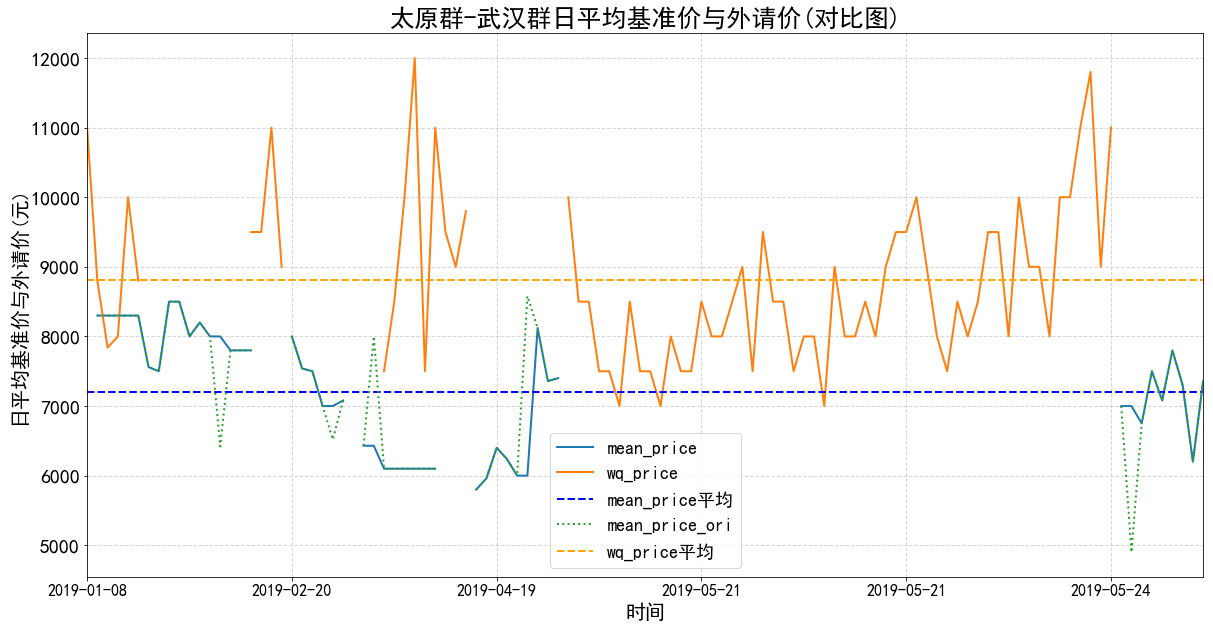

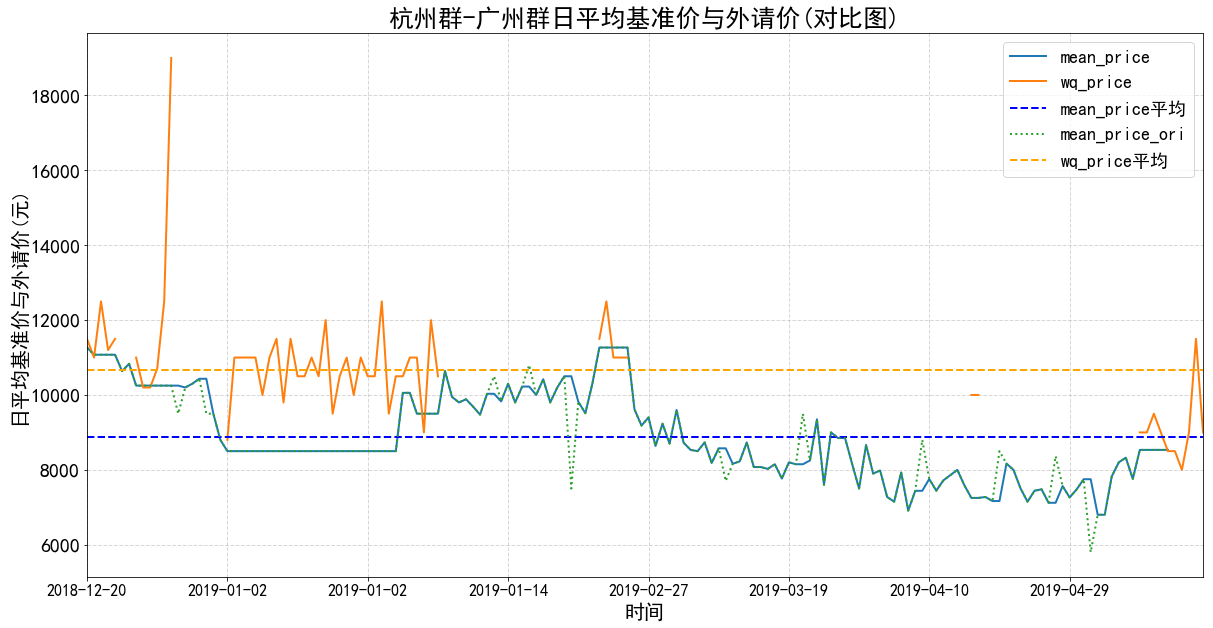

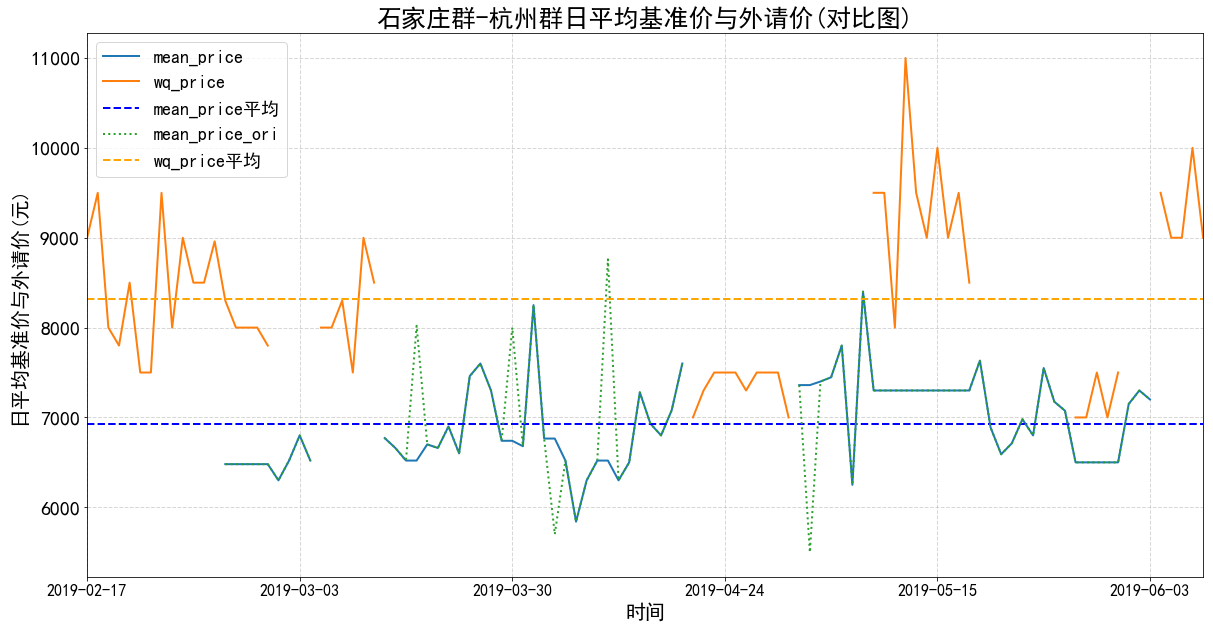

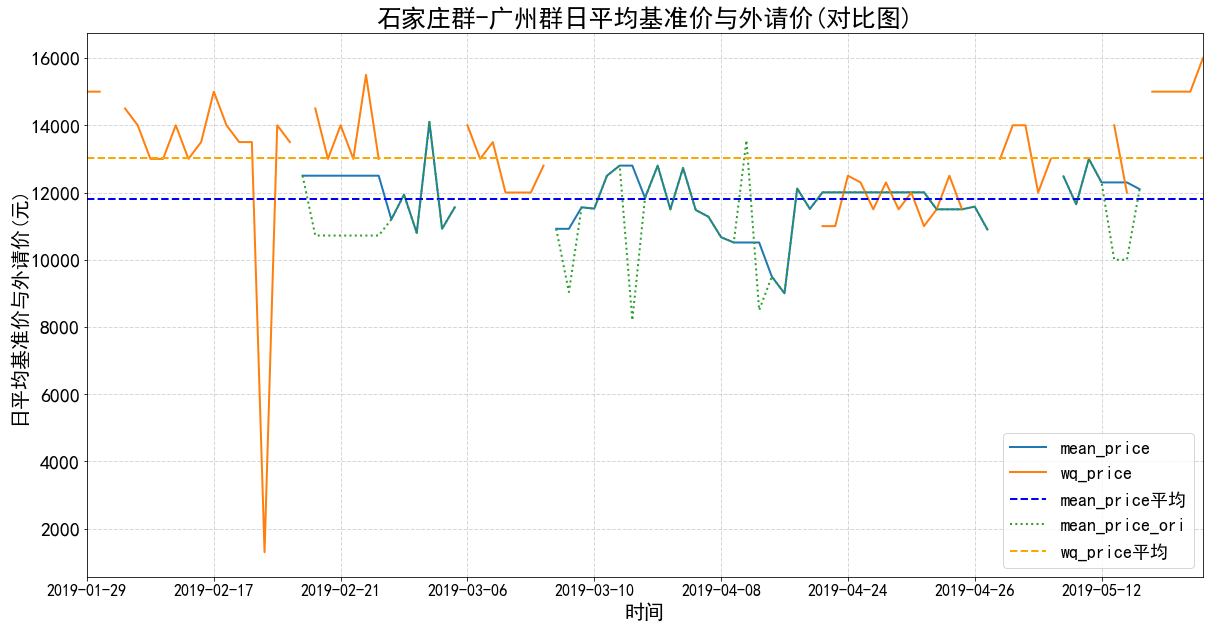

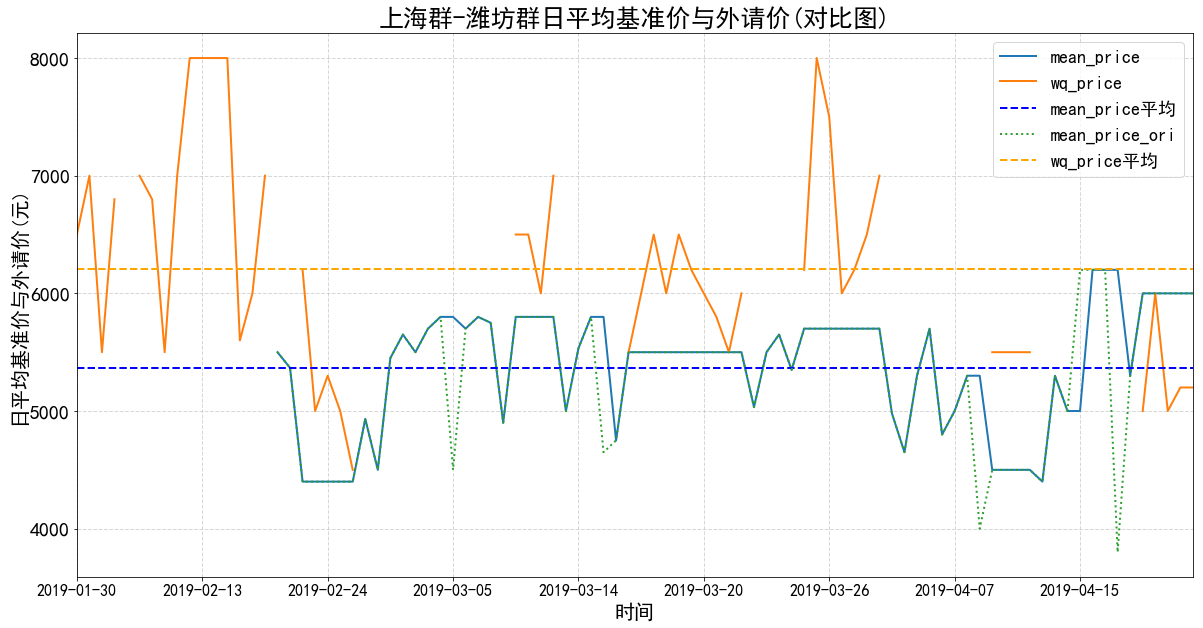

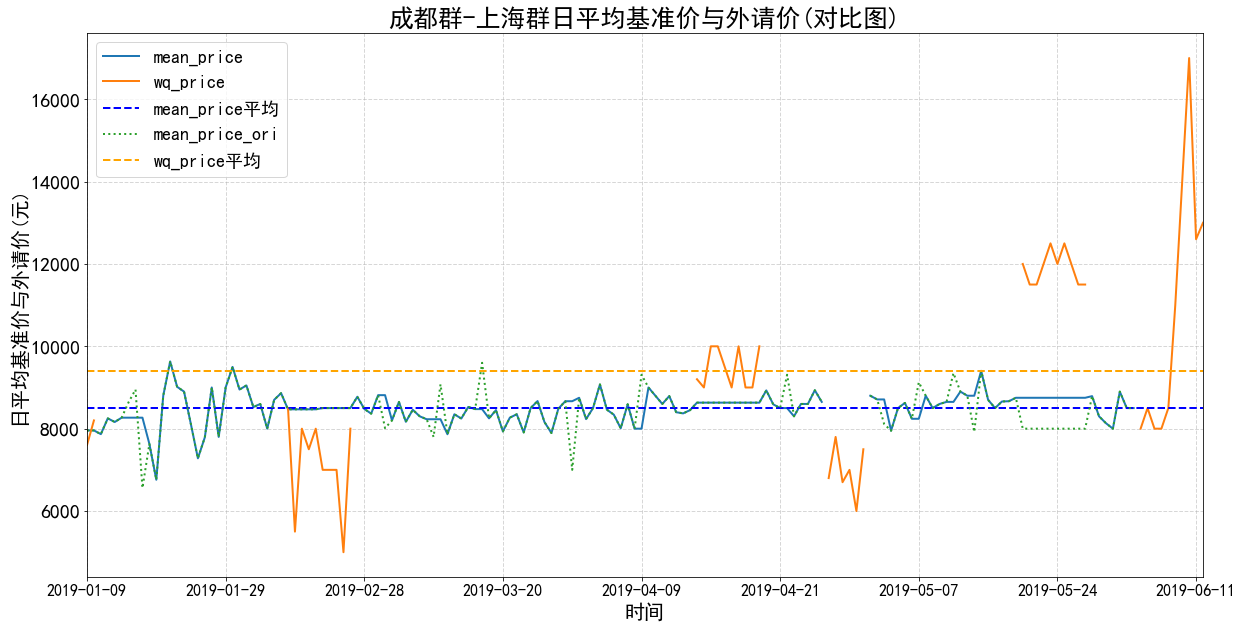

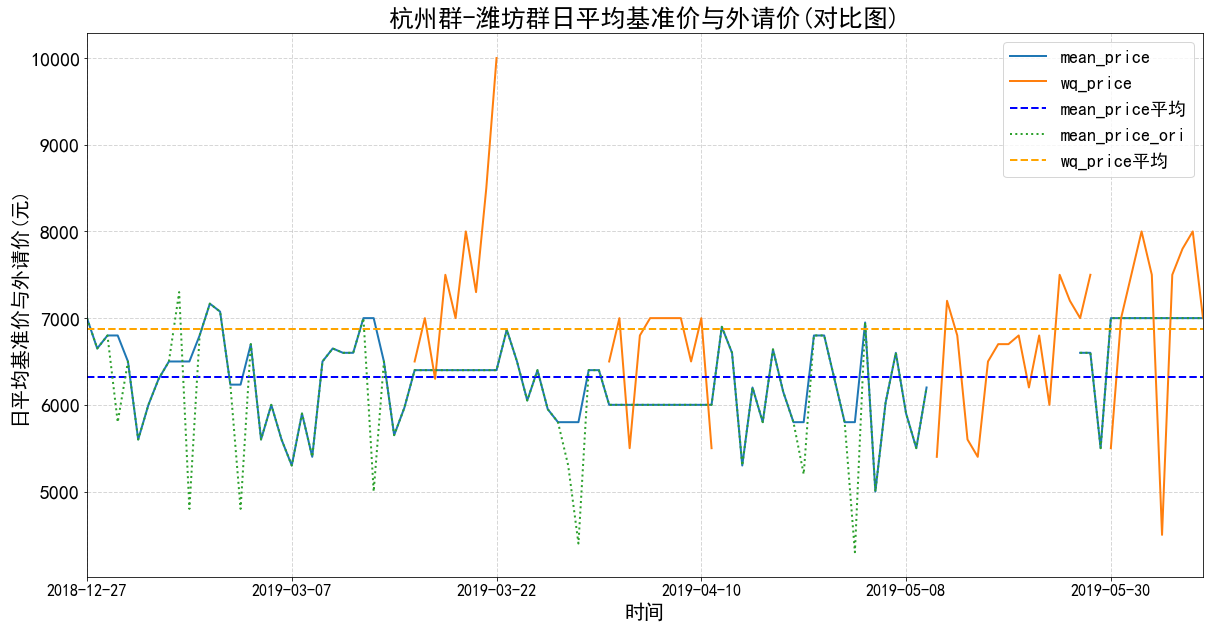

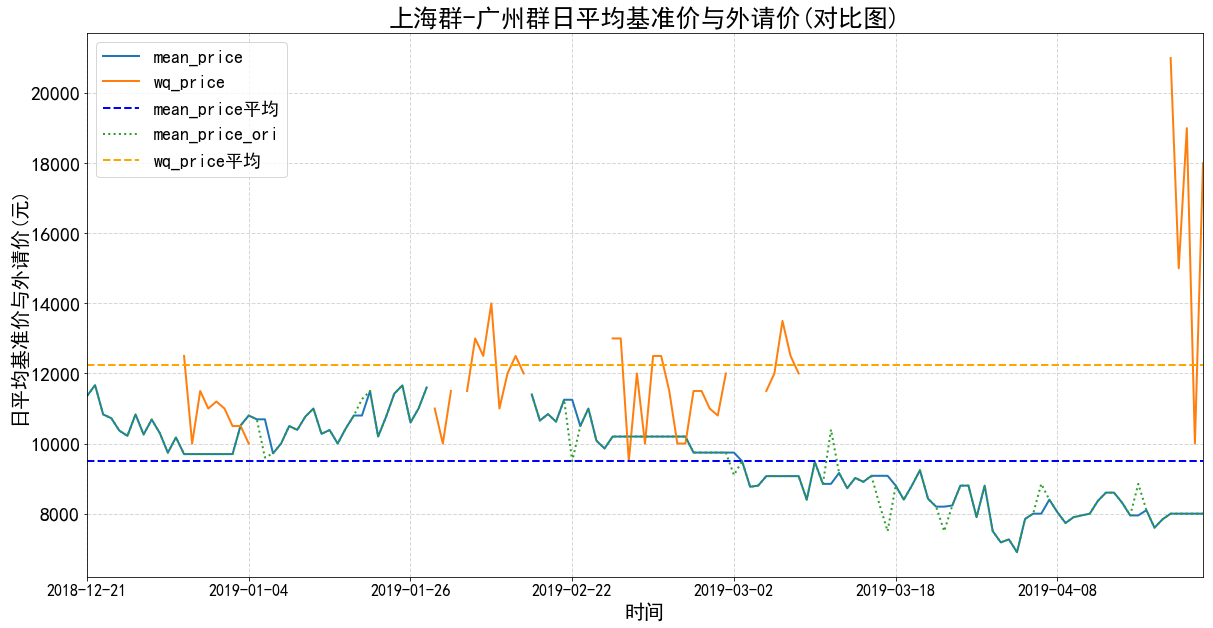

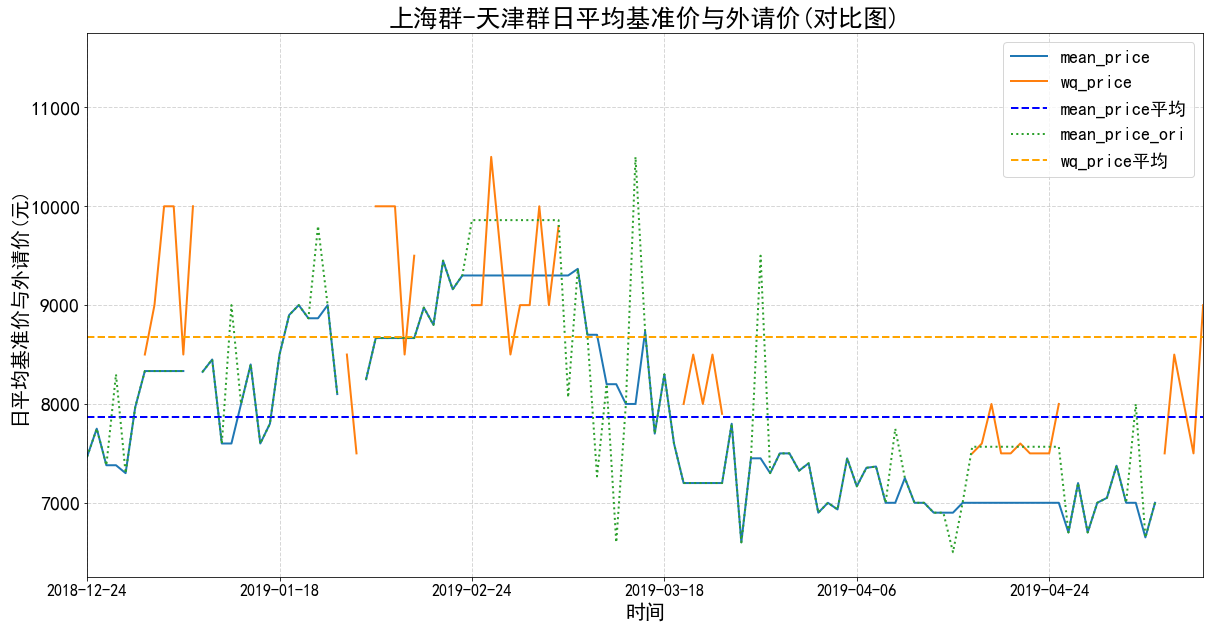

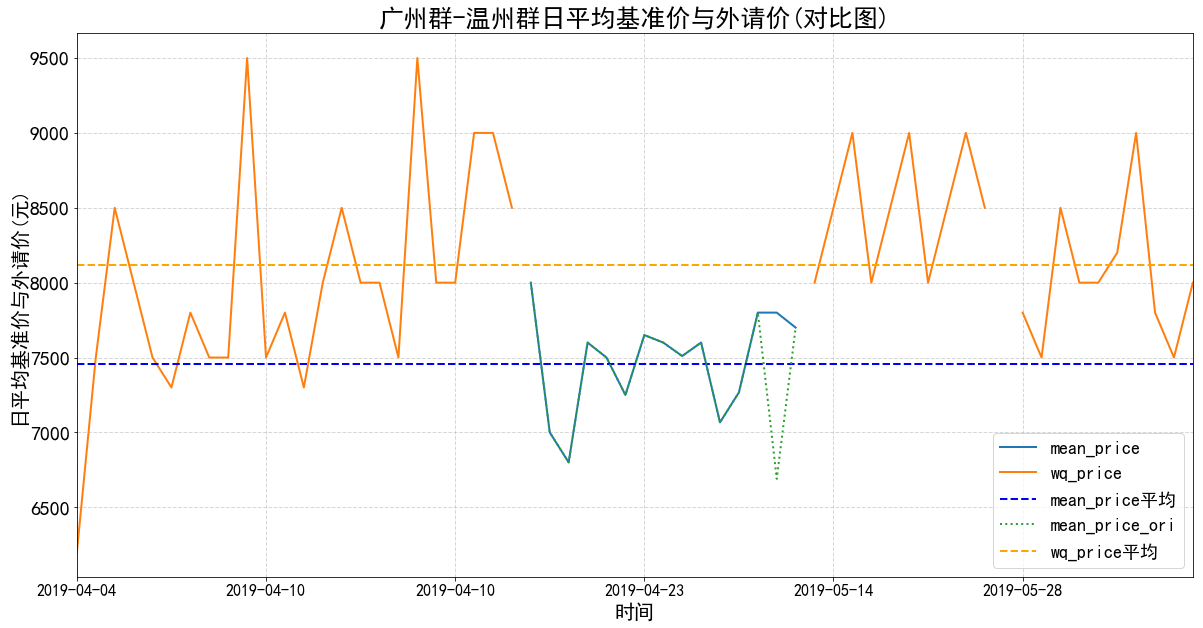

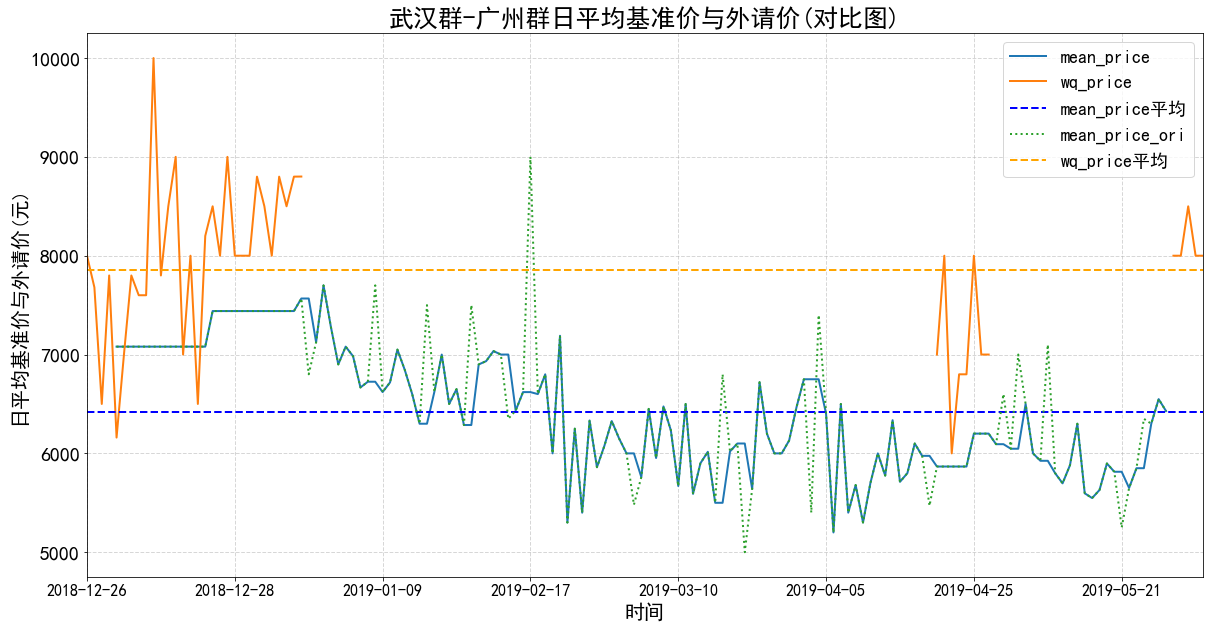

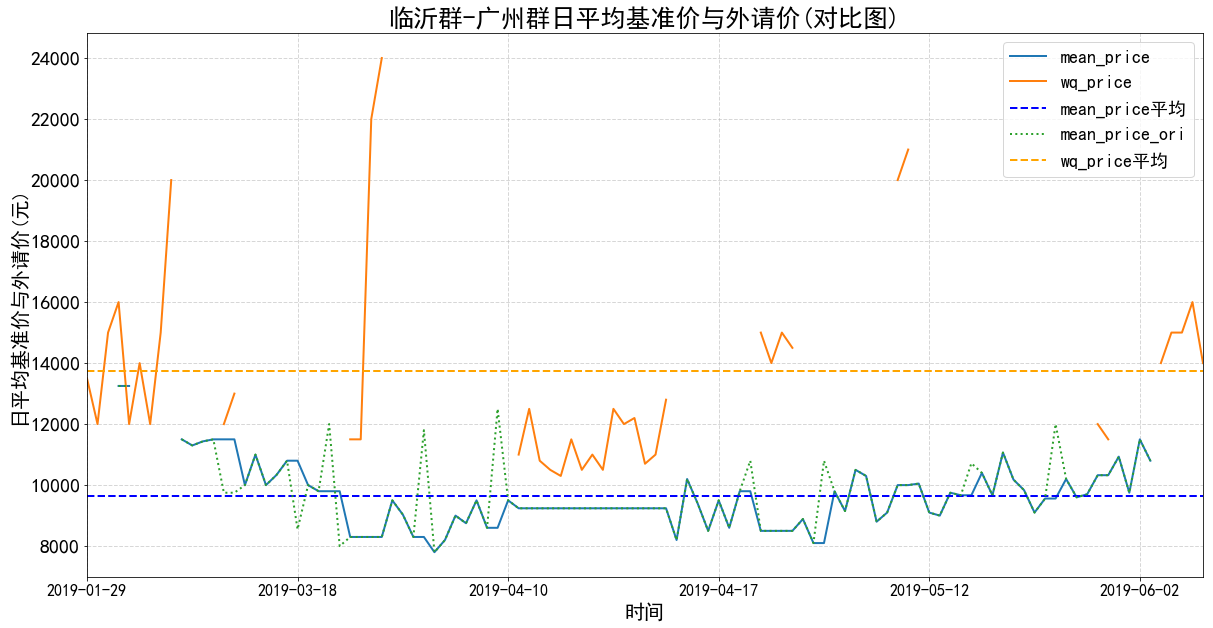

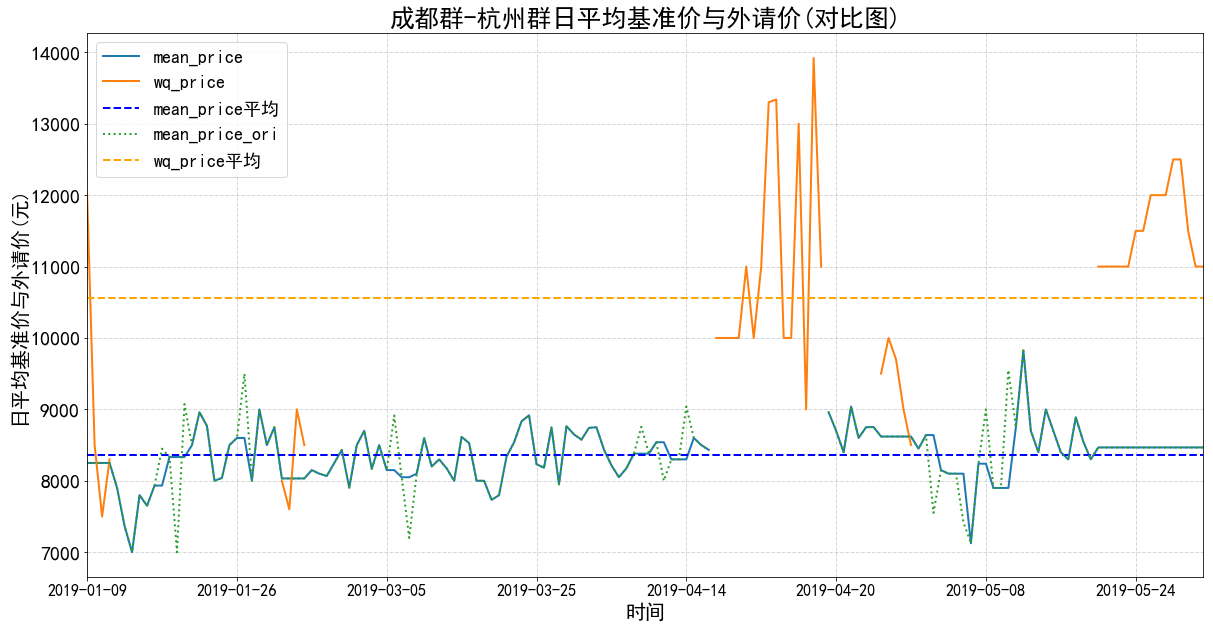

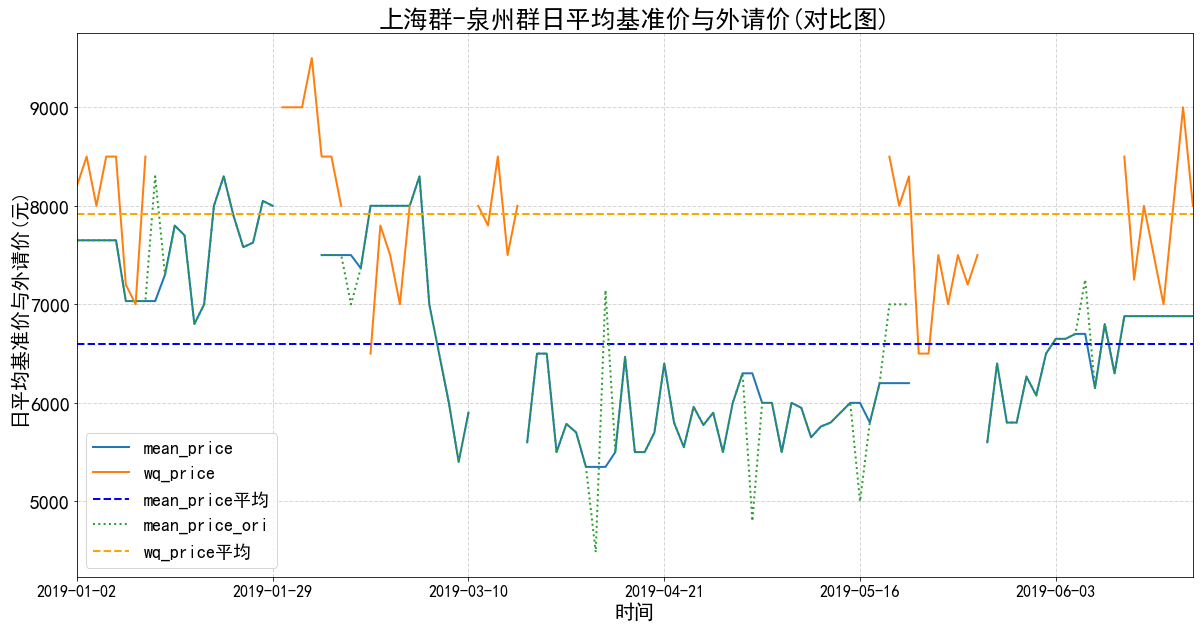

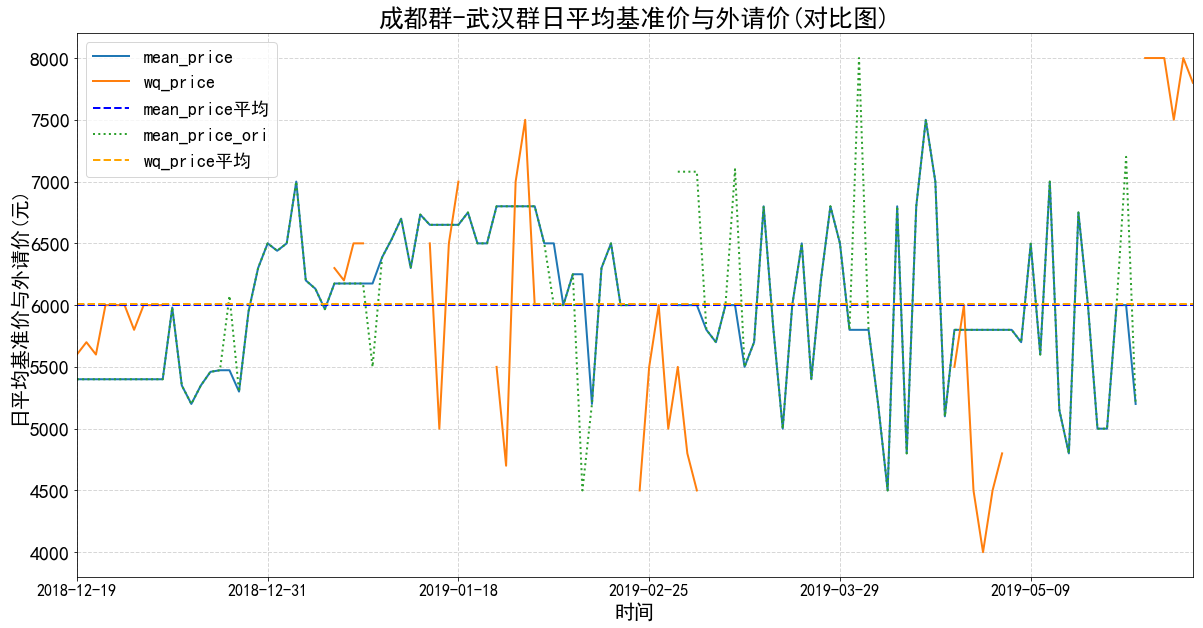

In [255]:
n  = len(wq_sub['cluster_line'].value_counts())
for i in range(0,15):
    dfnew = merge(wq_sub,df_mean,i)

对于这10个城市，所有城市群的外请价格都比同一时间段的市场基准价高。

In [244]:
def distplot(wq_sub,df_mean,i):
    
    dif_line = wq_sub['cluster_line'].value_counts()


    t1 = wq_sub.loc[wq_sub['cluster_line']==dif_line.index[i],:]        ######外请
    t2 = df_mean.loc[df_mean['line']==dif_line.index[i],:]             #### 基准价

    start = t1.iloc[0,5]
    end = t1.iloc[-1,5]
    
    
    t3 = t2.loc[(t2['date']>=start) & (t2['date'] <=end),:]
    
    ############ set index to date

    df2 = pd.merge(t3,t1,on='date',how='outer')
    df2 = df2.sort_values(by='date')
    df2 = df2.set_index('date')
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.kdeplot(df2['mean_price'], color='red',shade='True', label='市场价')
    sns.kdeplot(df2['wq_price'], color='green', shade='True',label='外请价格')
    plt.axvline(x=df2['mean_price'].mean(), c="red", ls="--", lw=2,label='市场价平均')
    plt.axvline(x=df2['wq_price'].mean(), c="green", ls="--", lw=2,label='外请价平均')

    plt.xlabel('价格',fontsize=20)
    plt.ylabel('概率密度',fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)     

    plt.grid(which='major',linestyle='--', linewidth=1,alpha=0.5)
    plt.legend(fontsize='18')
    plt.title(dif_line.index[i]+'日平均基准价与外请价(pdf)',fontsize=25)
    
    plt.subplot(1,2,2)
    plt.hist(df2['mean_price'], density=True,cumulative=True,color='red',label='市场价',alpha=0.5)
    plt.hist(df2['wq_price'], density=True,cumulative=True,color='green',label='外请价',alpha=0.5)
    plt.axhline(y=0.5, c="orange", ls="--")
    plt.xlabel('价格',fontsize=20)
    plt.ylabel('质量密度',fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)     

    plt.grid(which='major',linestyle='--', linewidth=1,alpha=0.5)
    plt.legend(fontsize='18')
    plt.title(dif_line.index[i]+'日平均基准价与外请价(cdf)',fontsize=25)
    plt.show()

### CDF AND PDF

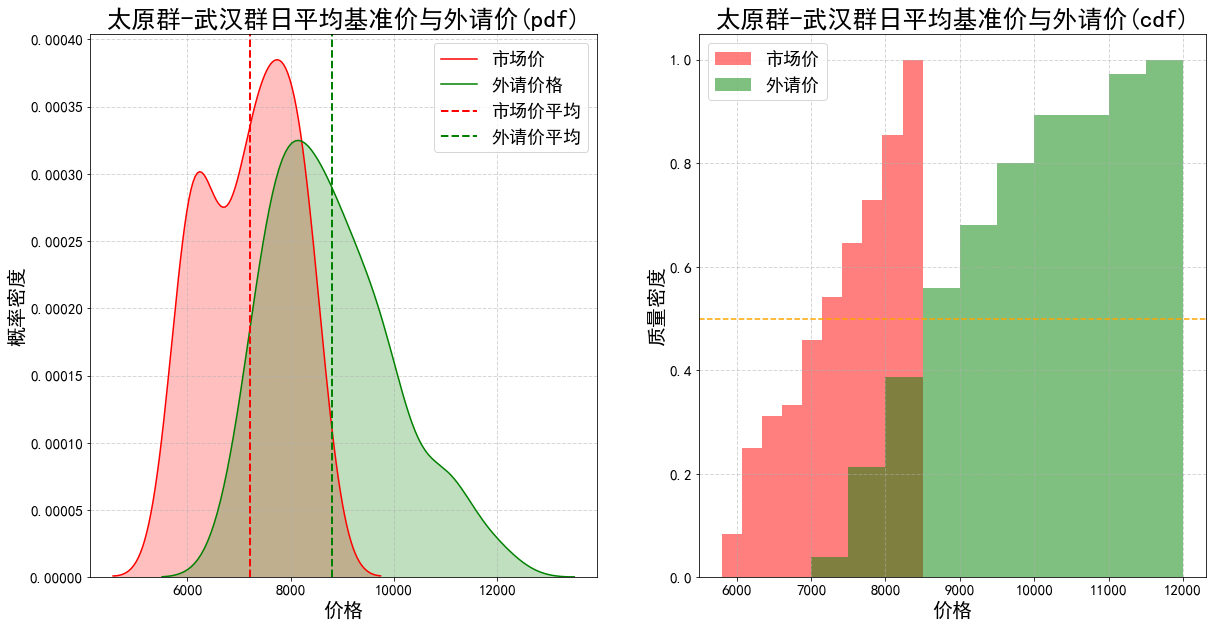

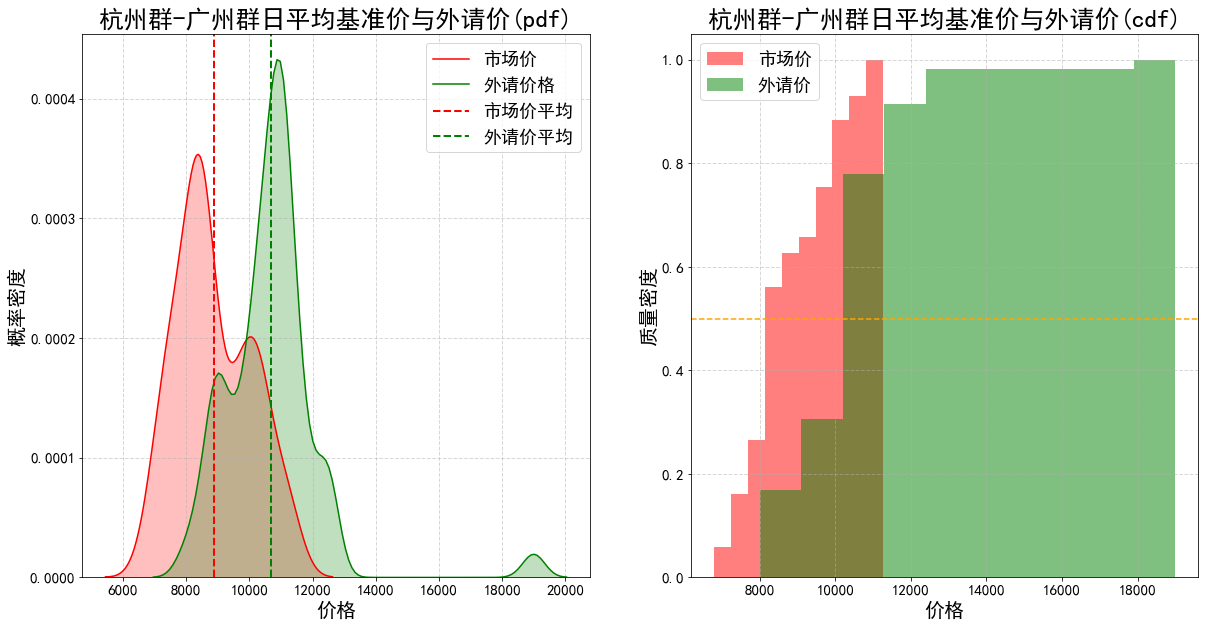

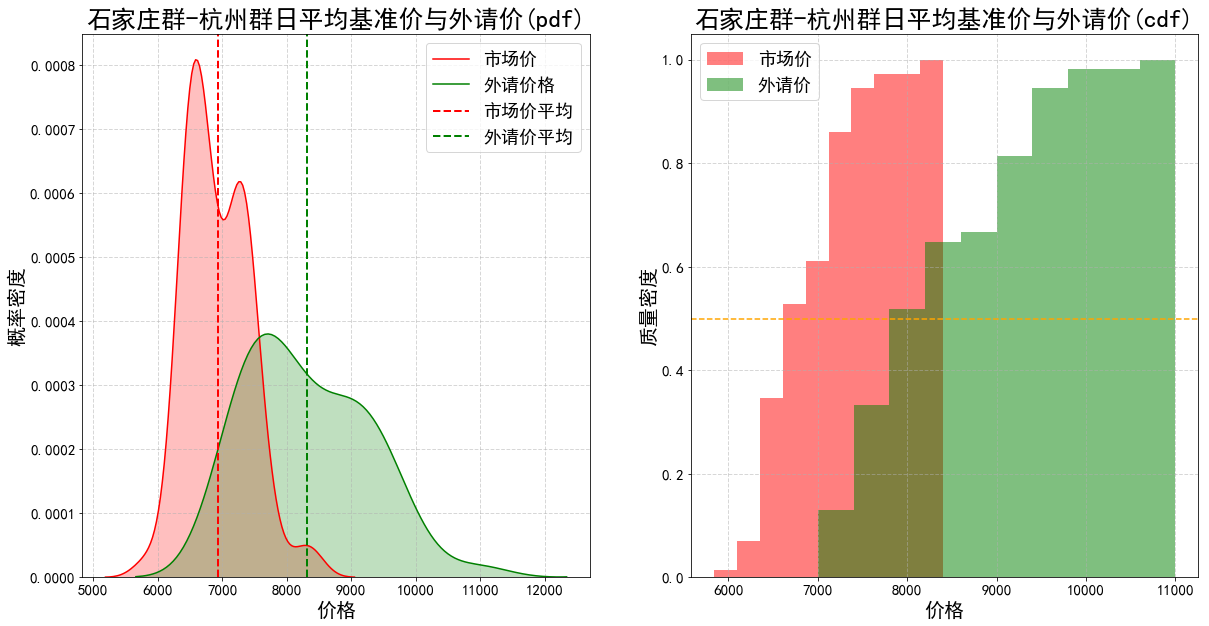

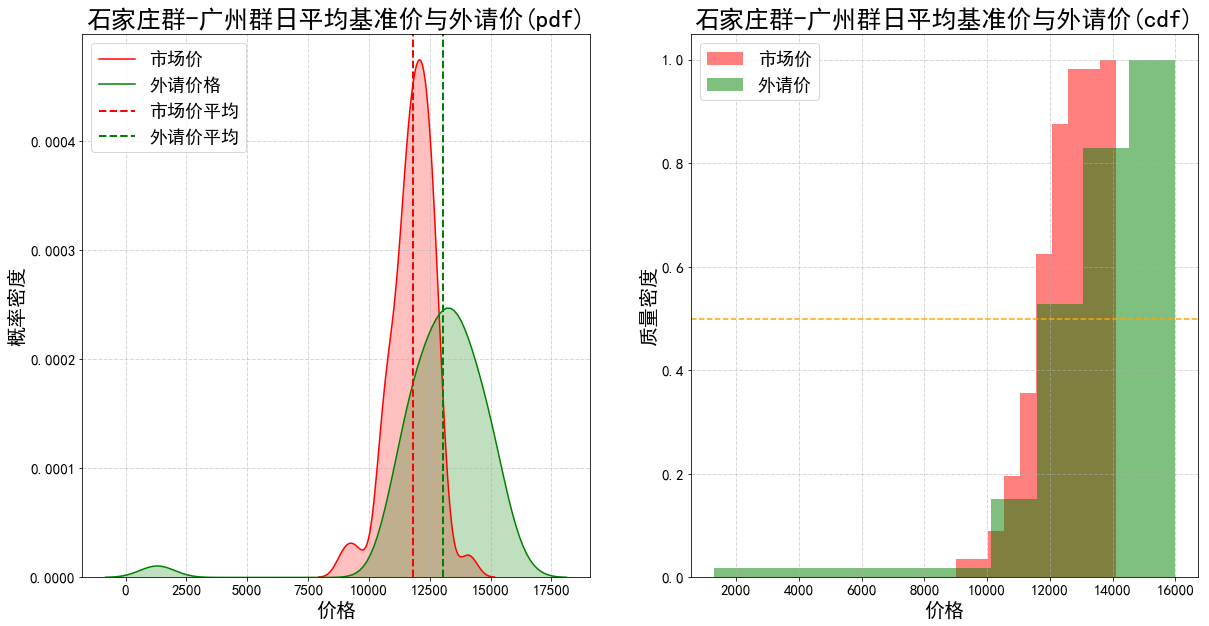

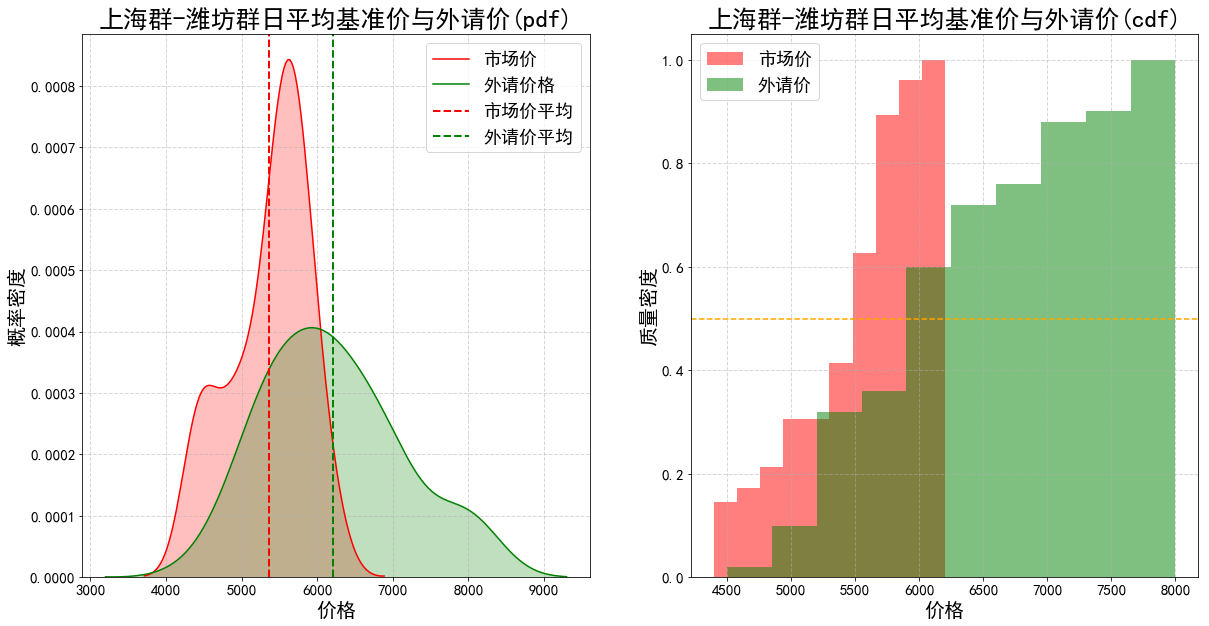

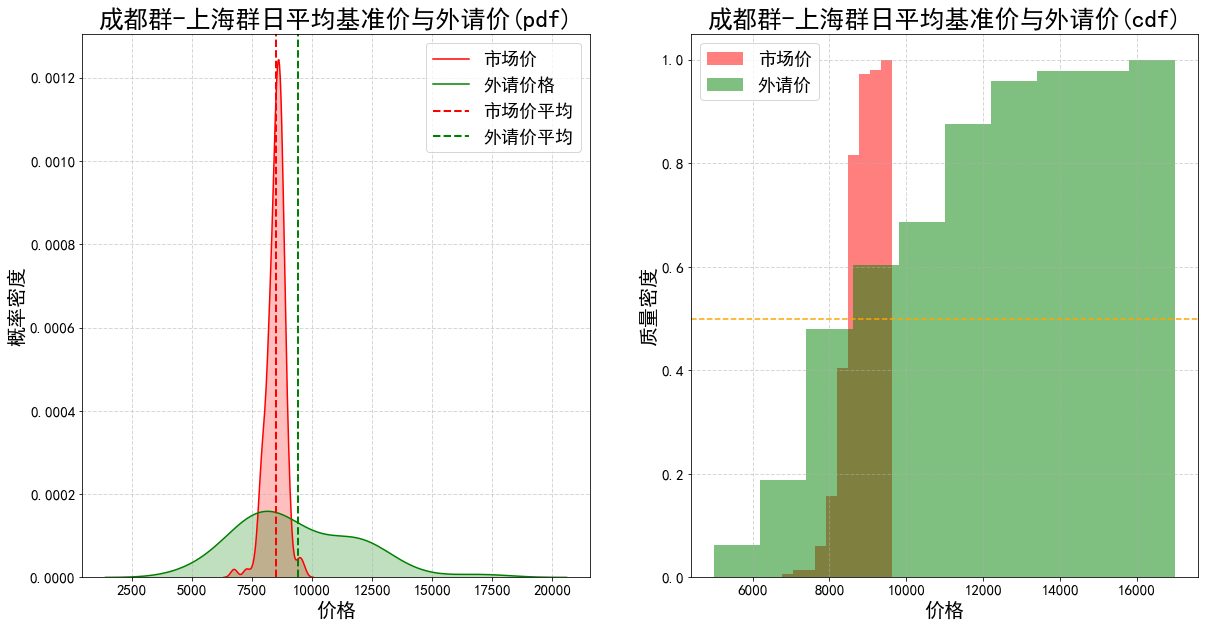

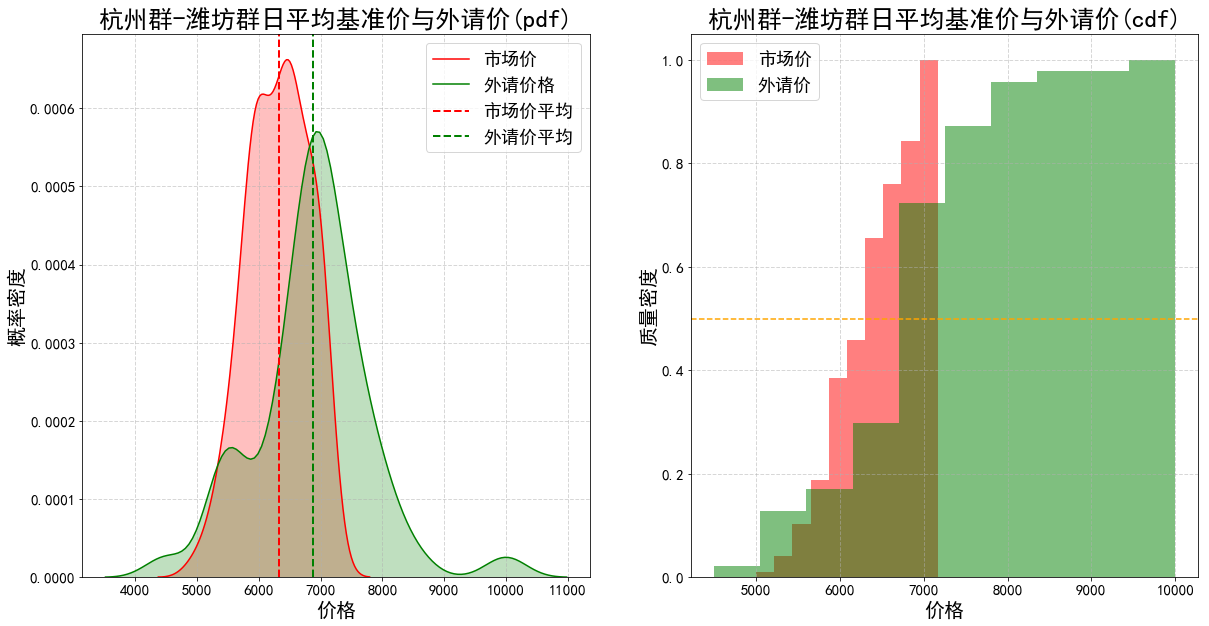

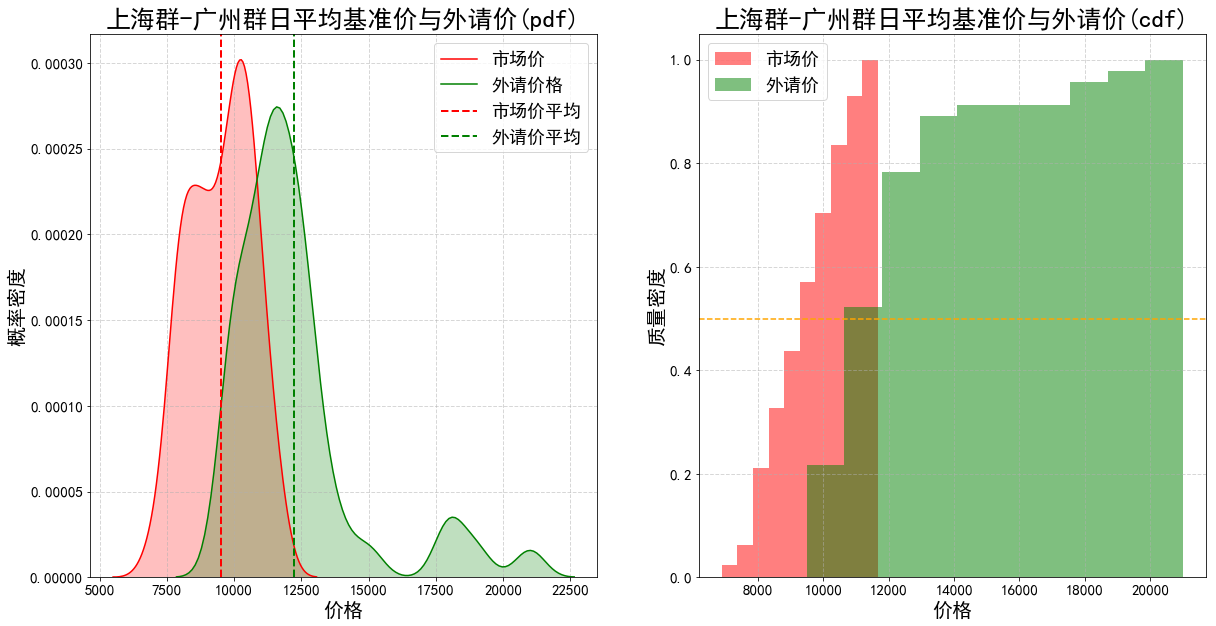

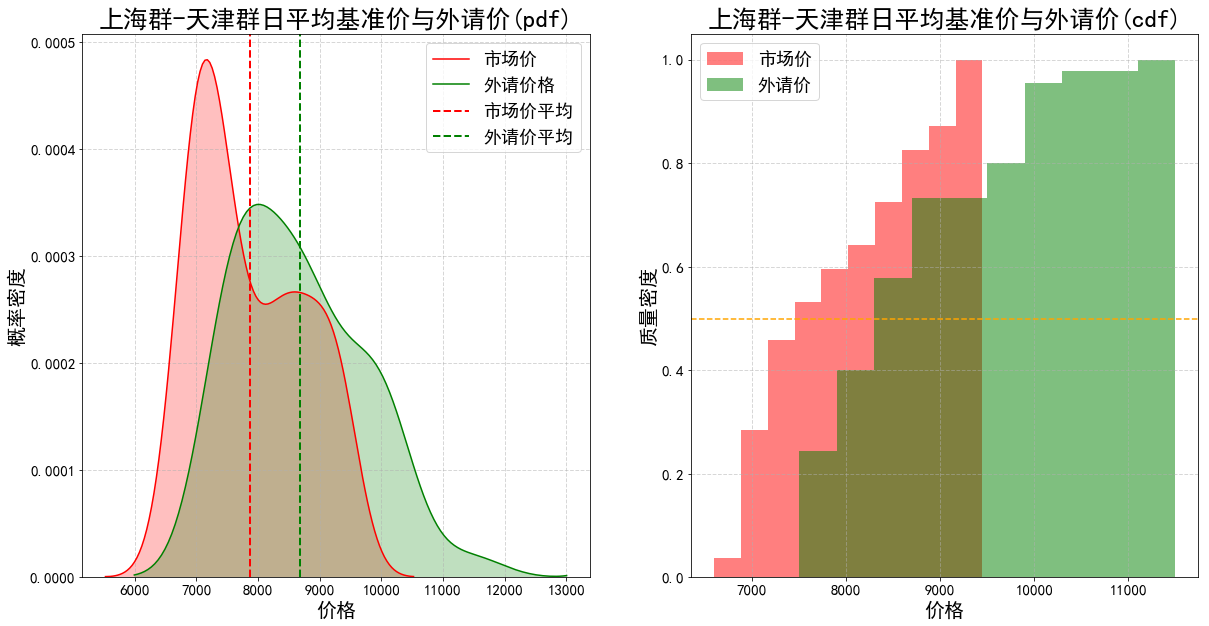

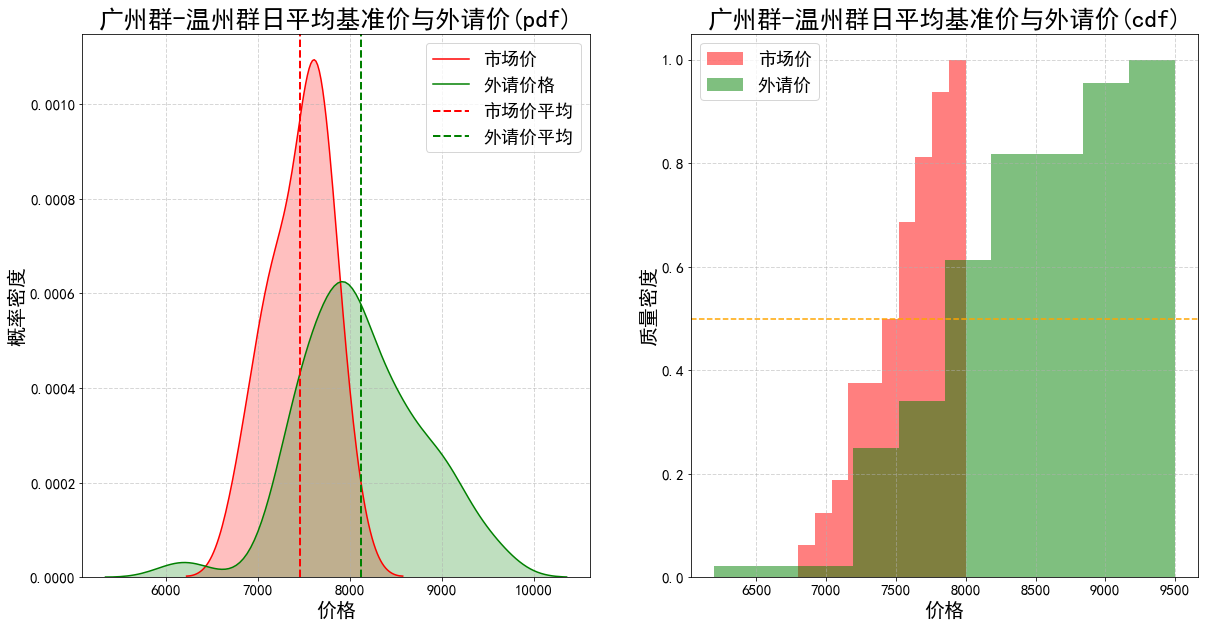

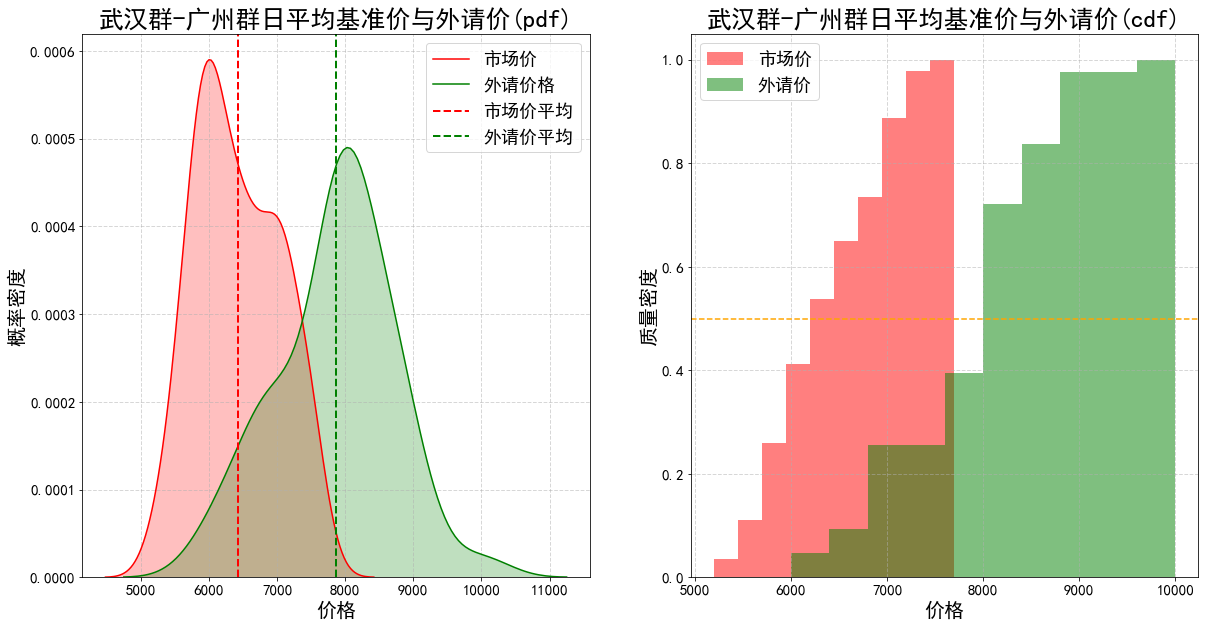

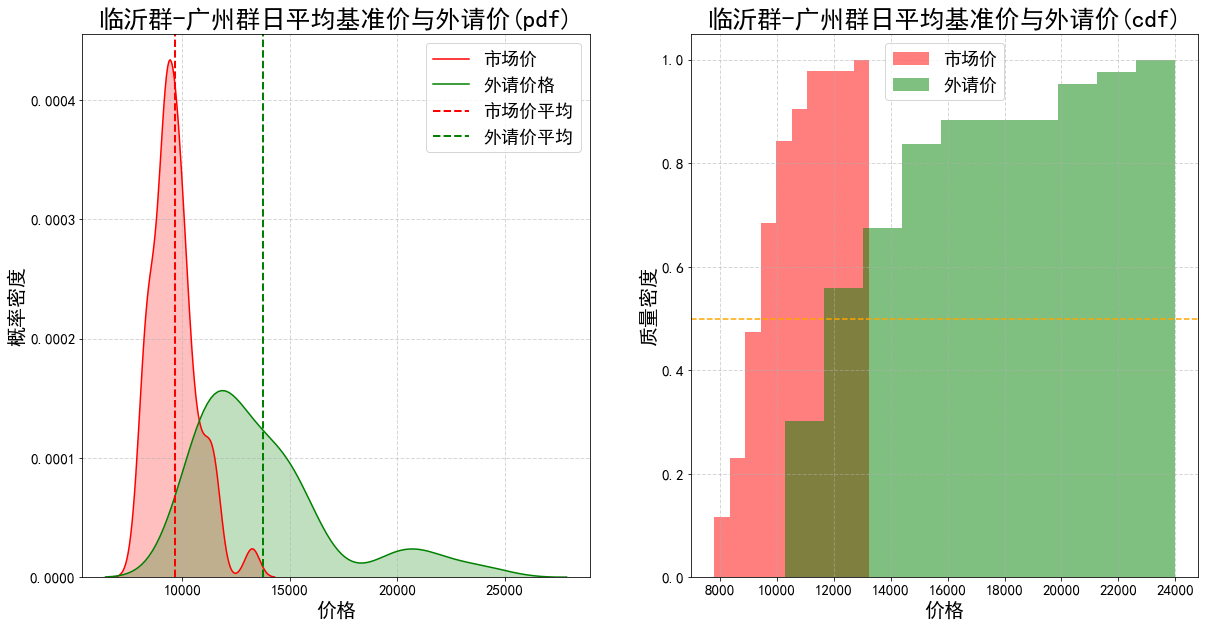

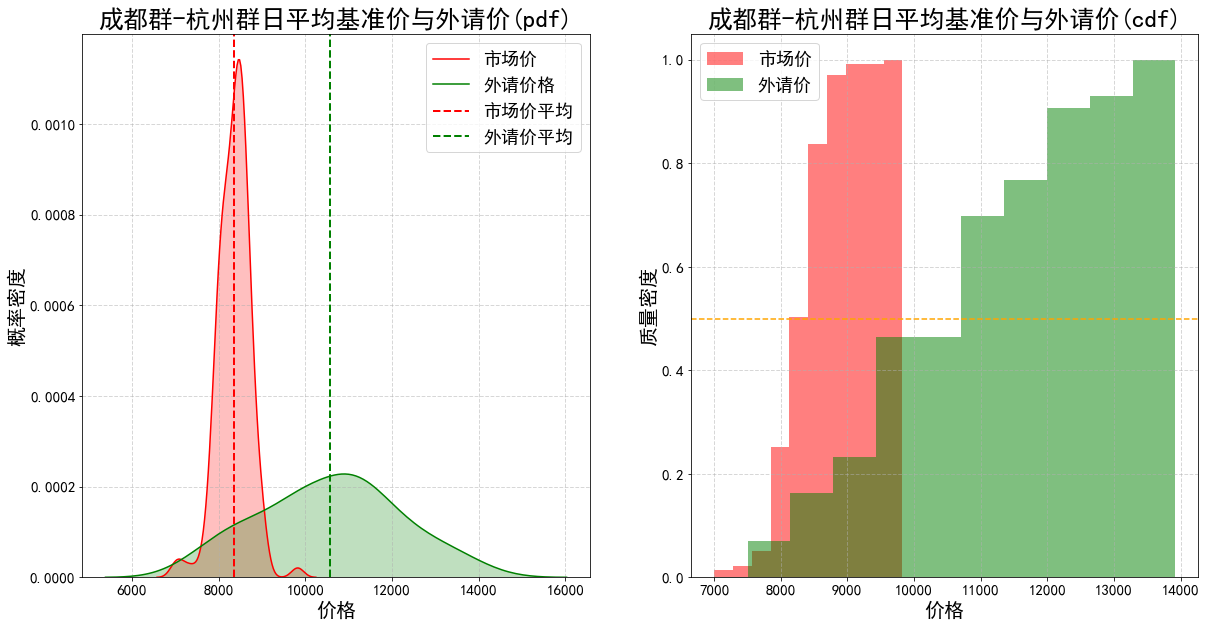

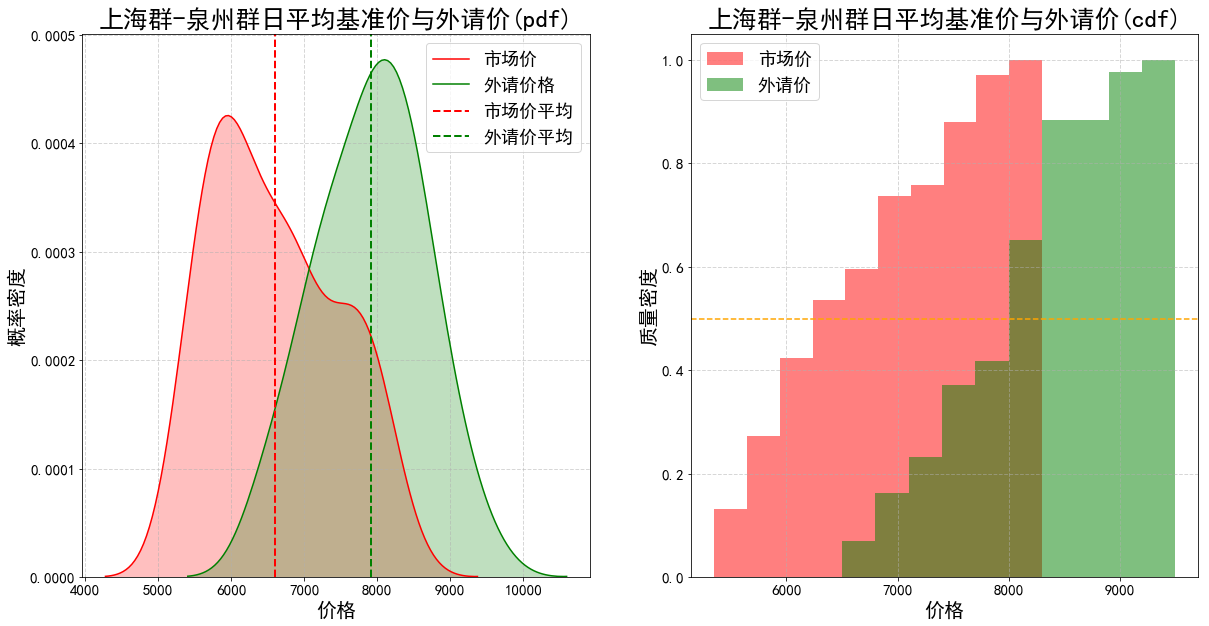

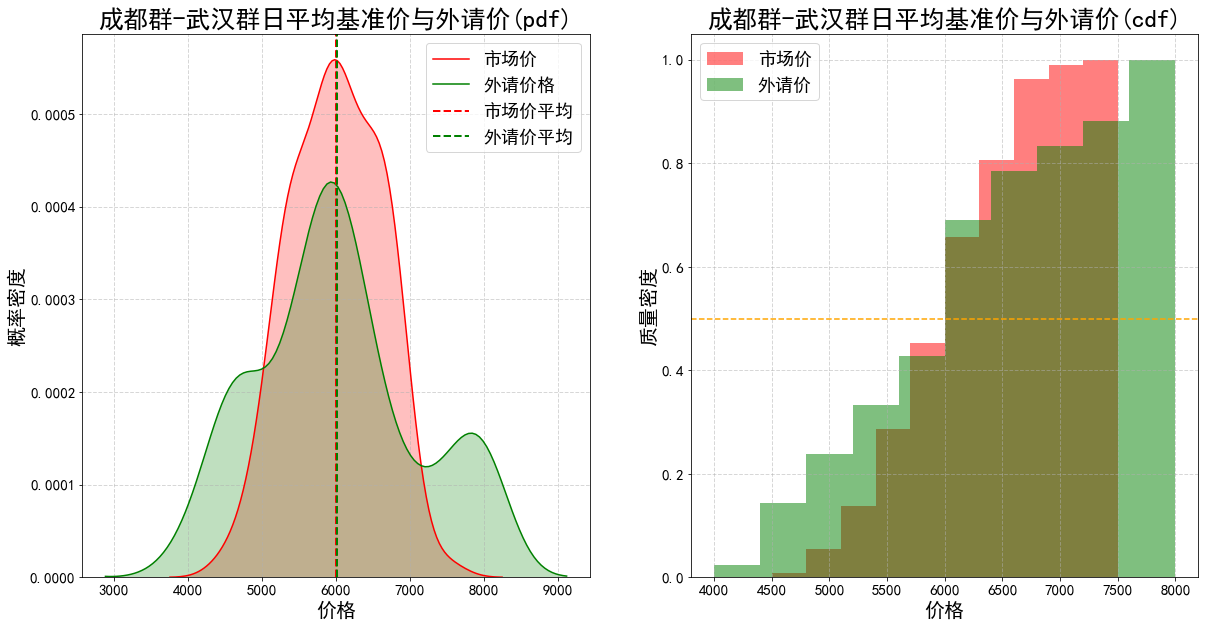

In [256]:
for i in range(0,15):
    distplot(wq_sub,df_mean,i)

### 按照出发城市群，画出PDF与CDF
只选取外请记录大于5个的路线，取数据的方法同上，把所有数据汇合

In [294]:
a1 = wq['cluster_line'].value_counts()
line = list(a1[a1>5].index)
wq_5 = wq.loc[wq['cluster_line'].isin(line),:]

In [295]:
dfnew = pd.DataFrame(columns=['mean_price','from_city_cluster','to_city_cluster','wq_price','cluster_line'])

In [296]:
def from_cluster(wq_sub,df_mean,i,dfnew):
    
    dif_line = wq_sub['cluster_line'].value_counts()


    t1 = wq_sub.loc[wq_sub['cluster_line']==dif_line.index[i],:]        ######外请
    t2 = df_mean.loc[df_mean['line']==dif_line.index[i],:]             #### 基准价

    start = t1.iloc[0,5]
    end = t1.iloc[-1,5]
    
    
    t3 = t2.loc[(t2['date']>=start) & (t2['date'] <=end),:]
    
    ############ set index to date
    
    
    df2 = pd.merge(t3,t1,on='date',how='outer')
    df2 = df2.sort_values(by='date')
    df2 = df2.set_index('date')
    
    df3 = df2[['mean_price','from_city_cluster','to_city_cluster','wq_price','cluster_line']]
    dfnew = dfnew.append(df3)
    
    return dfnew

In [298]:
n = len(set(wq_5['cluster_line']))
for i in range(0,n):
    dfnew = from_cluster(wq_5,df_mean,i,dfnew)

### 选取这20个出发城市群

In [310]:
dfnew['from_city_cluster'].value_counts()[:20]

成都群       578
上海群       424
西安群       410
杭州群       402
郑州群       368
广州群       365
临沂群       285
石家庄群      253
武汉群       249
太原群       232
南京群       213
重庆主城区群    188
天津群       170
乌鲁木齐群     154
南昌群       148
包头群       136
潍坊群       131
泉州群       107
温州群        75
合肥群        71
Name: from_city_cluster, dtype: int64

In [303]:
def distplot2(dfnew,i):
    
    dif = dfnew['from_city_cluster'].value_counts()
    df2 = dfnew.loc[dfnew['from_city_cluster']==dif.index[i],:]
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.kdeplot(df2['mean_price'], color='red',shade='True', label='市场价')
    sns.kdeplot(df2['wq_price'], color='green', shade='True',label='外请价格')
    plt.axvline(x=df2['mean_price'].mean(), c="red", ls="--", lw=2,label='市场价平均')
    plt.axvline(x=df2['wq_price'].mean(), c="green", ls="--", lw=2,label='外请价平均')

    plt.xlabel('价格',fontsize=20)
    plt.ylabel('概率密度',fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)     

    plt.grid(which='major',linestyle='--', linewidth=1,alpha=0.5)
    plt.legend(fontsize='18')
    plt.title(dif.index[i]+'日平均基准价与外请价(pdf)',fontsize=25)
    
    plt.subplot(1,2,2)
    plt.hist(df2['mean_price'], density=True,cumulative=True,color='red',label='市场价',alpha=0.5)
    plt.hist(df2['wq_price'], density=True,cumulative=True,color='green',label='外请价',alpha=0.5)
    plt.axhline(y=0.5, c="orange", ls="--")
    plt.xlabel('价格',fontsize=20)
    plt.ylabel('质量密度',fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)     

    plt.grid(which='major',linestyle='--', linewidth=1,alpha=0.5)
    plt.legend(fontsize='18')
    plt.title(dif.index[i]+'日平均基准价与外请价(cdf)',fontsize=25)
    plt.show()

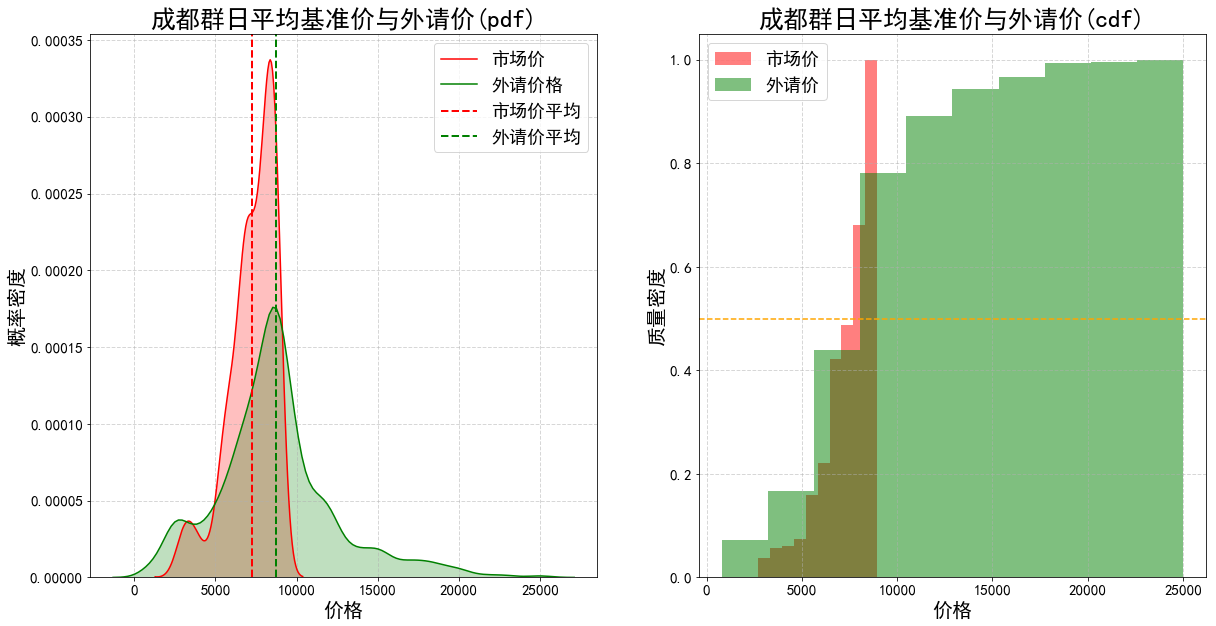

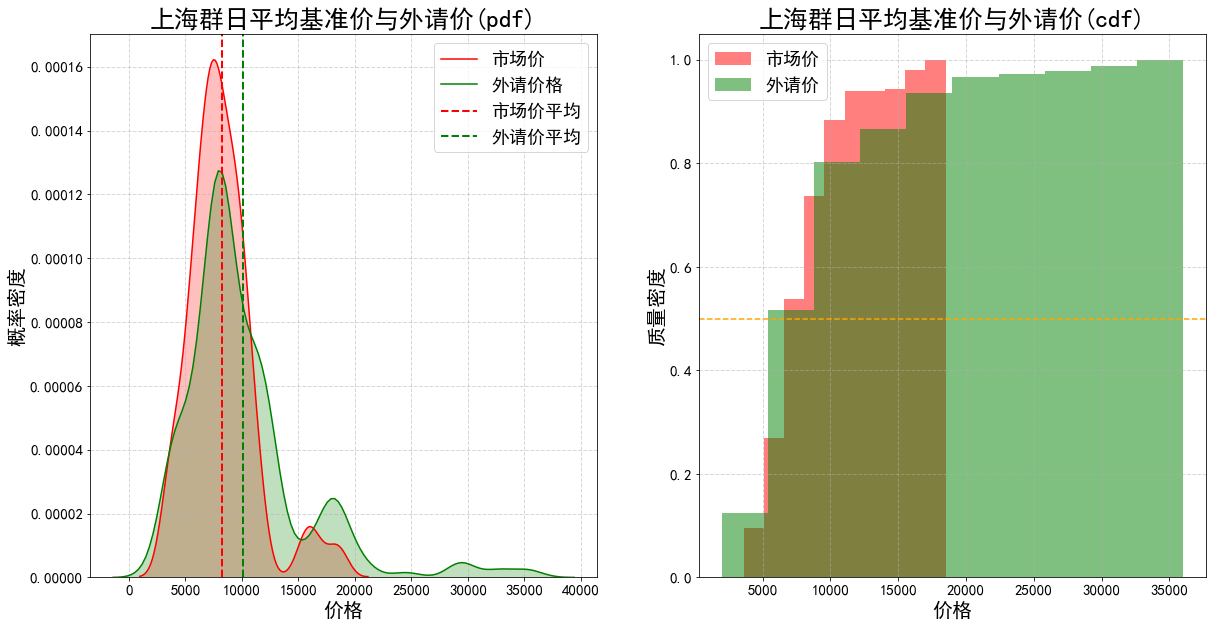

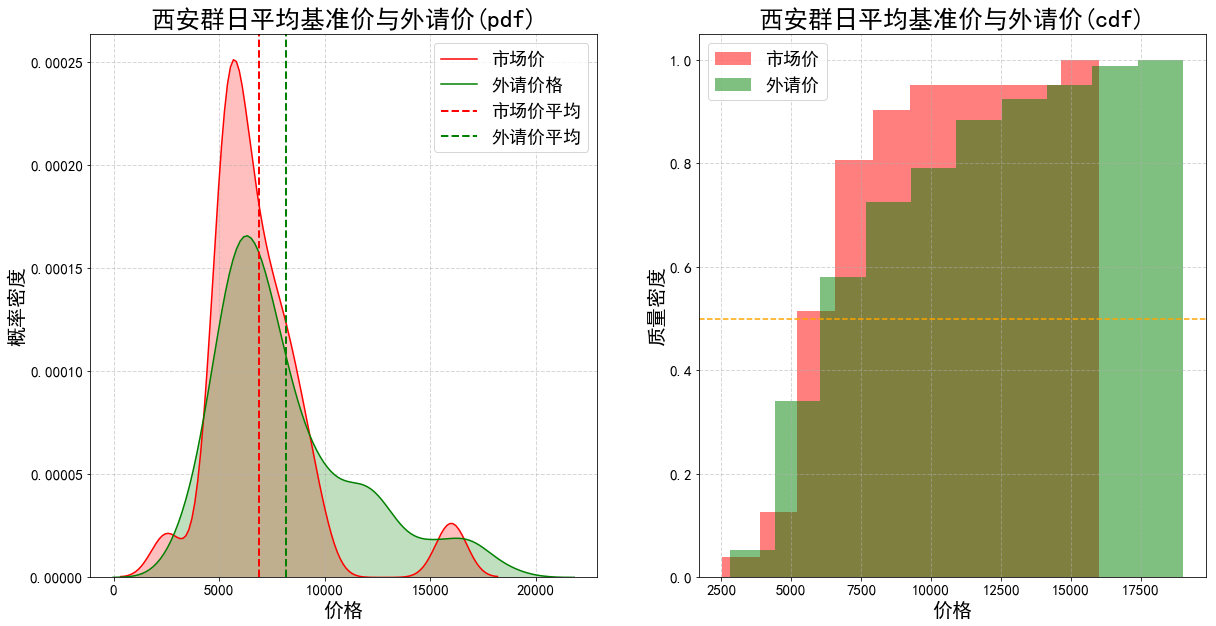

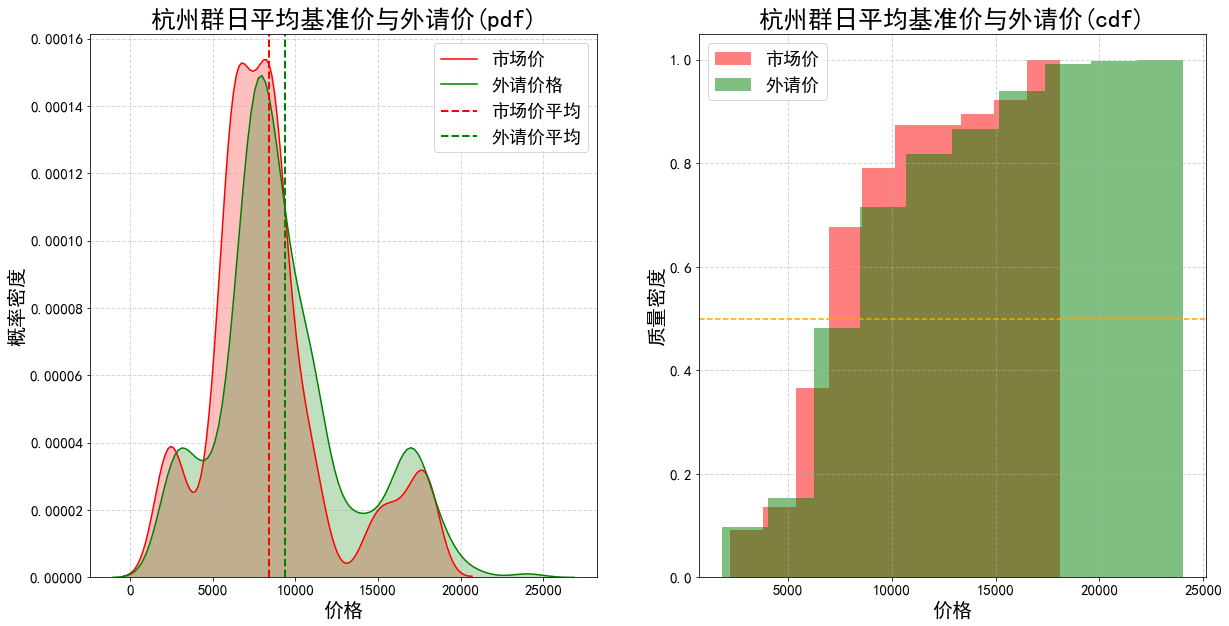

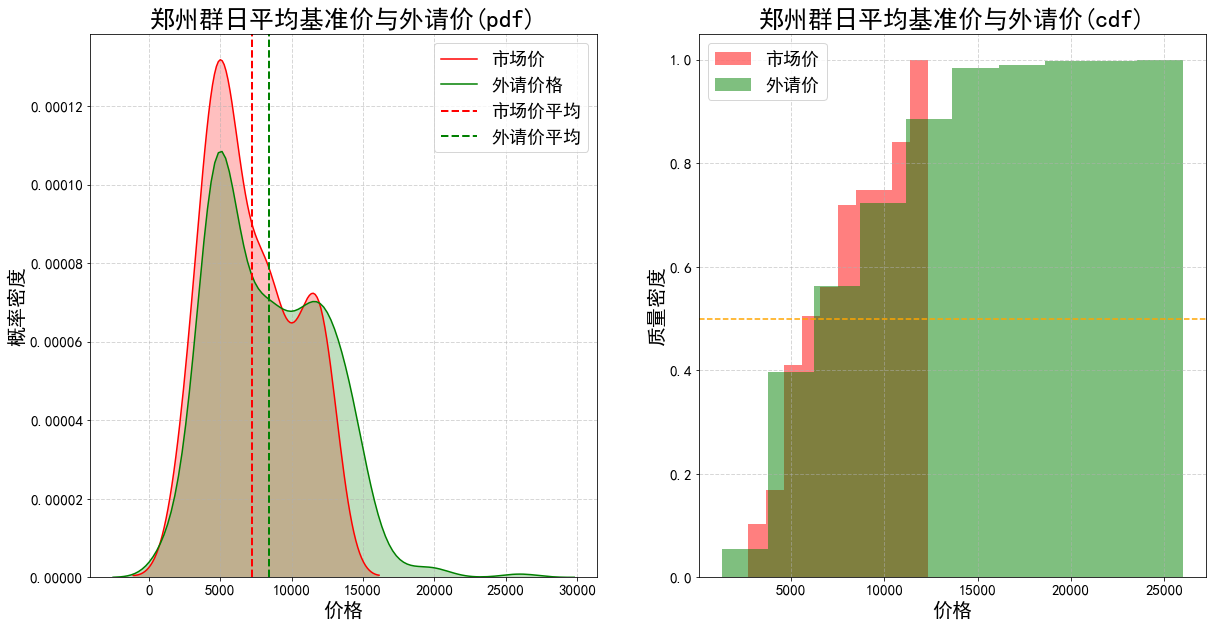

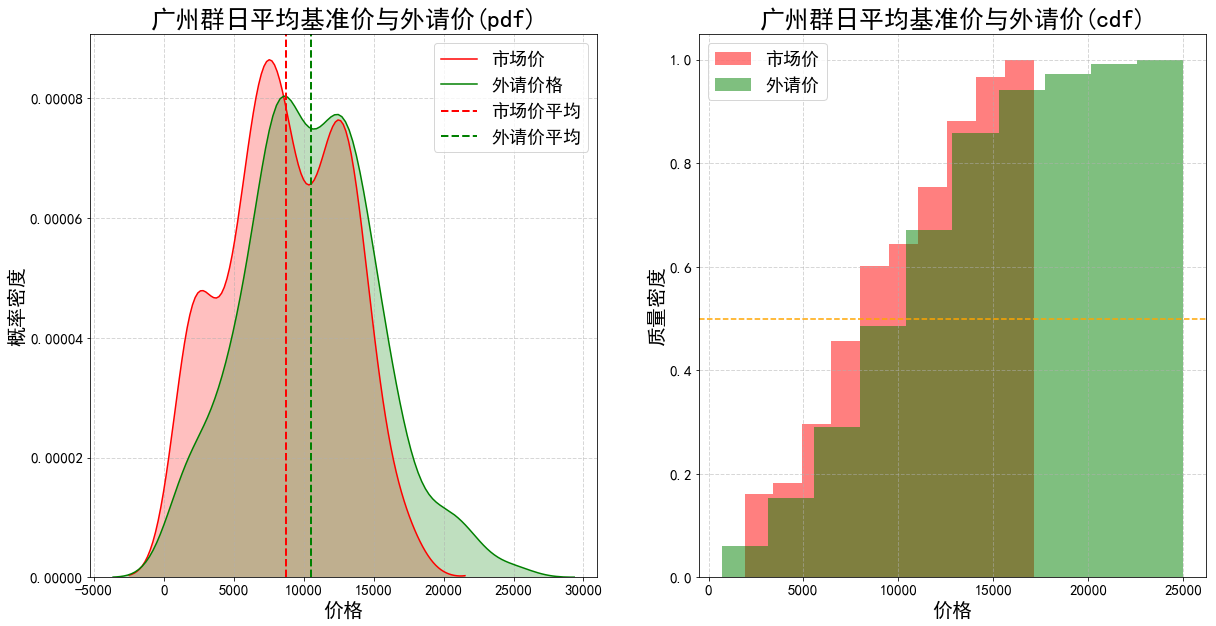

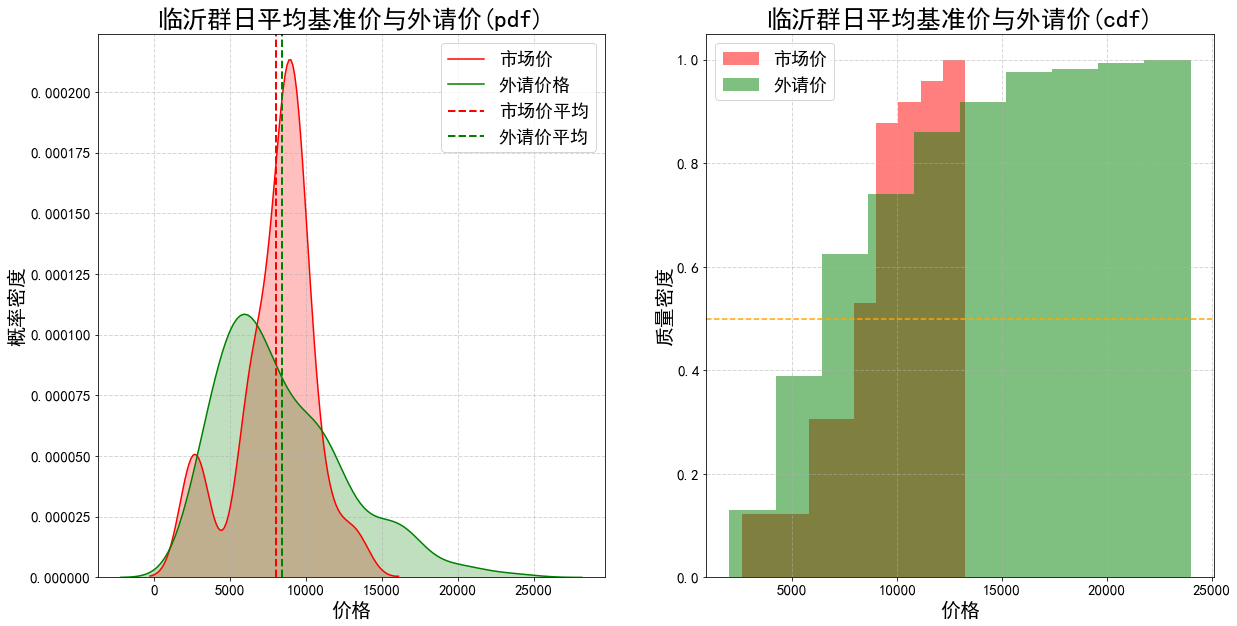

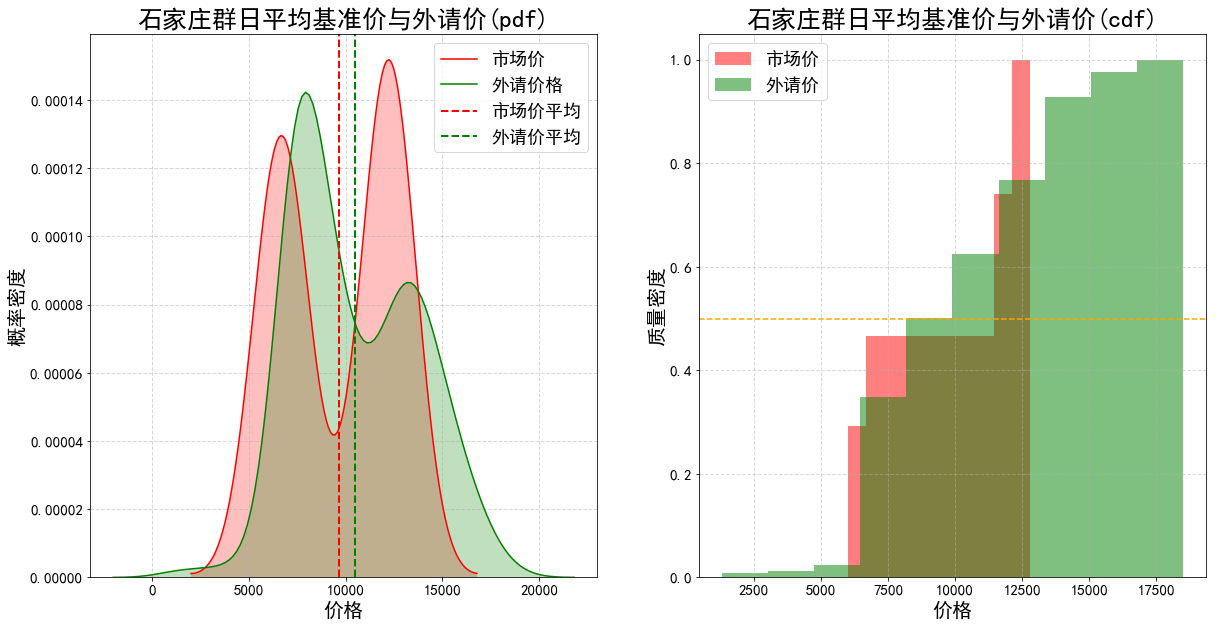

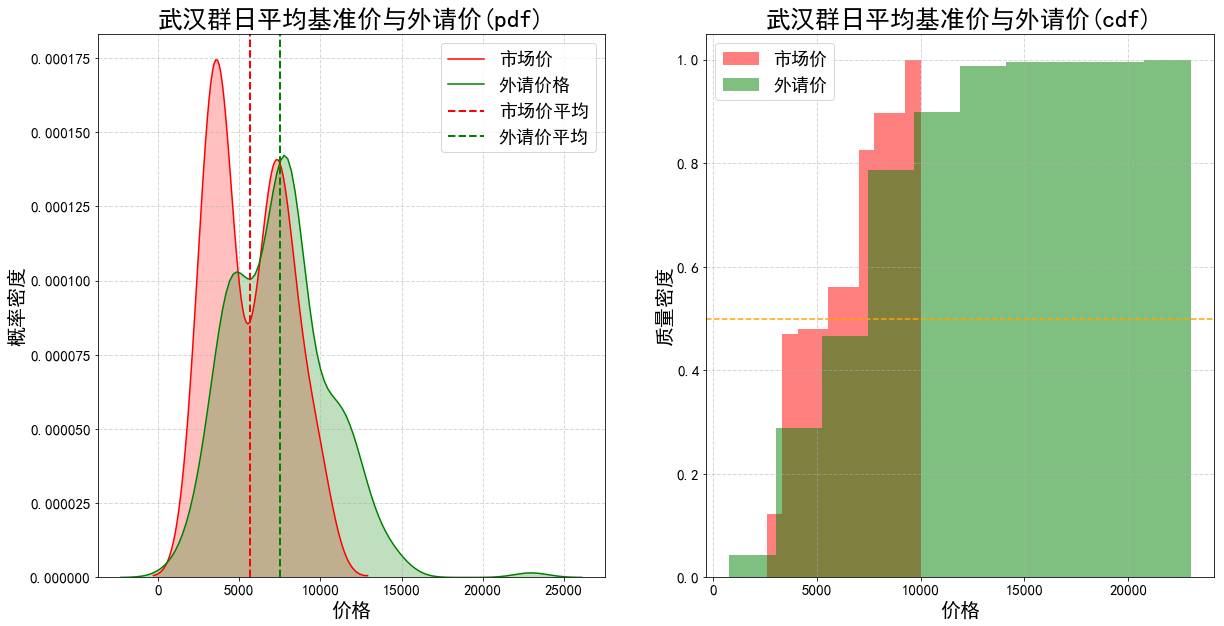

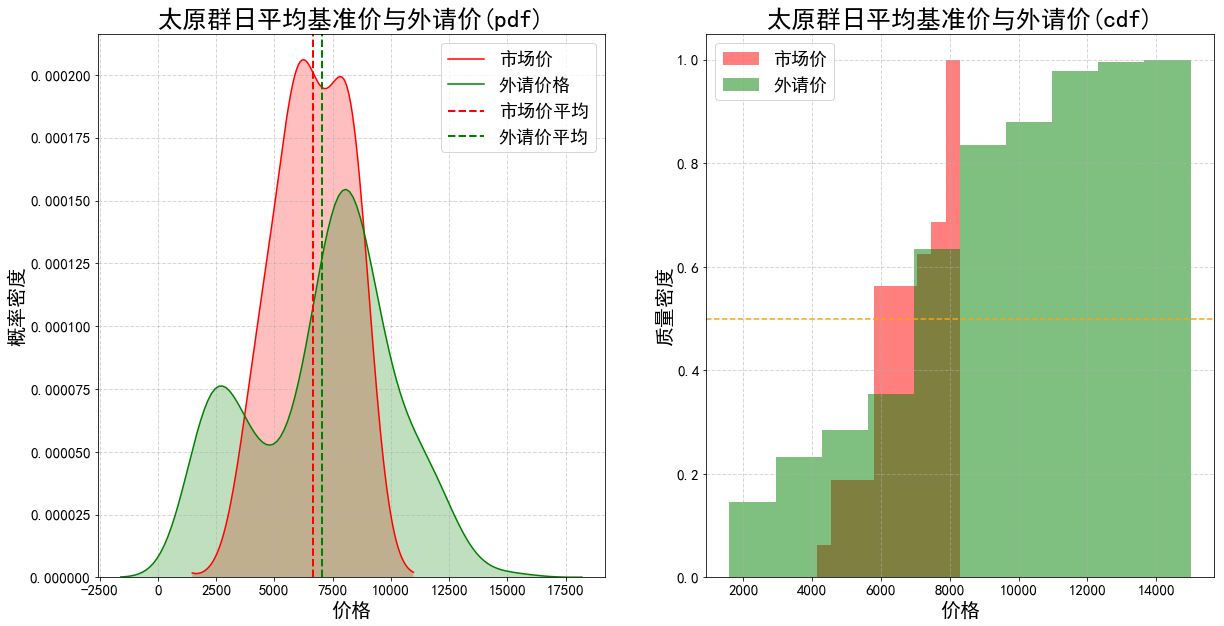

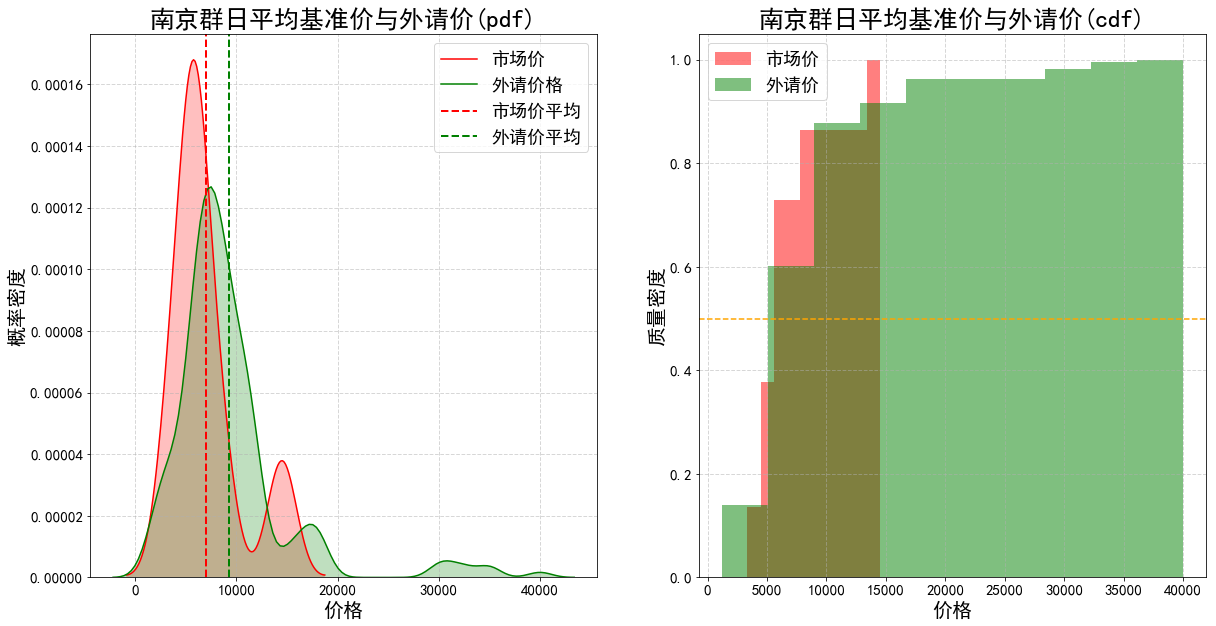

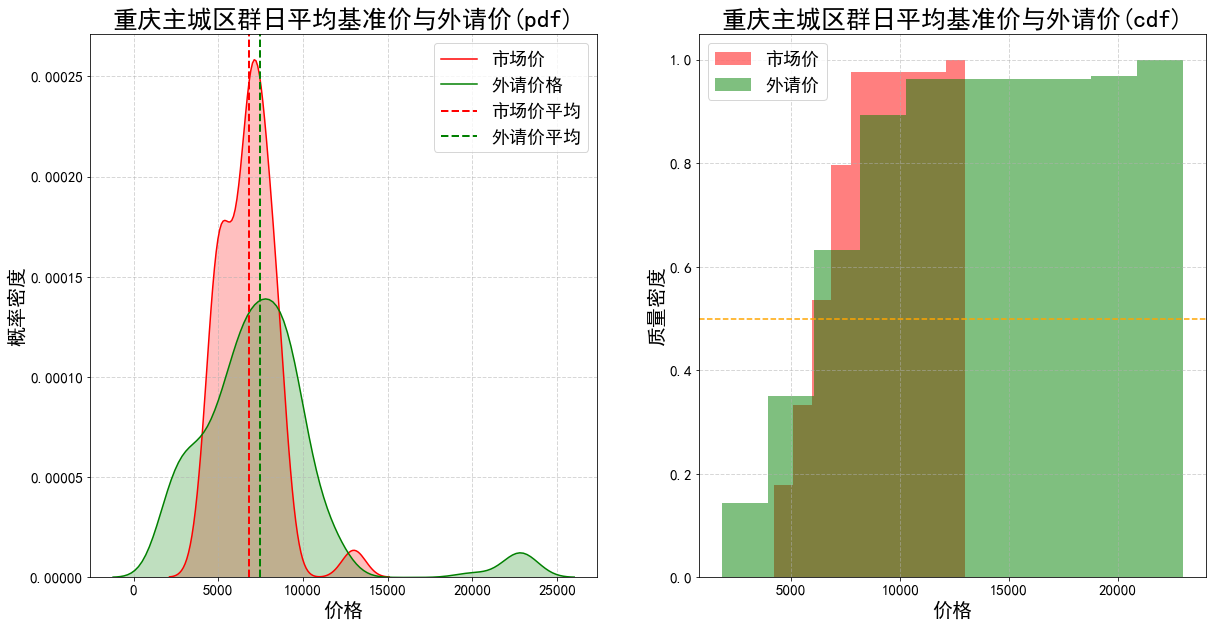

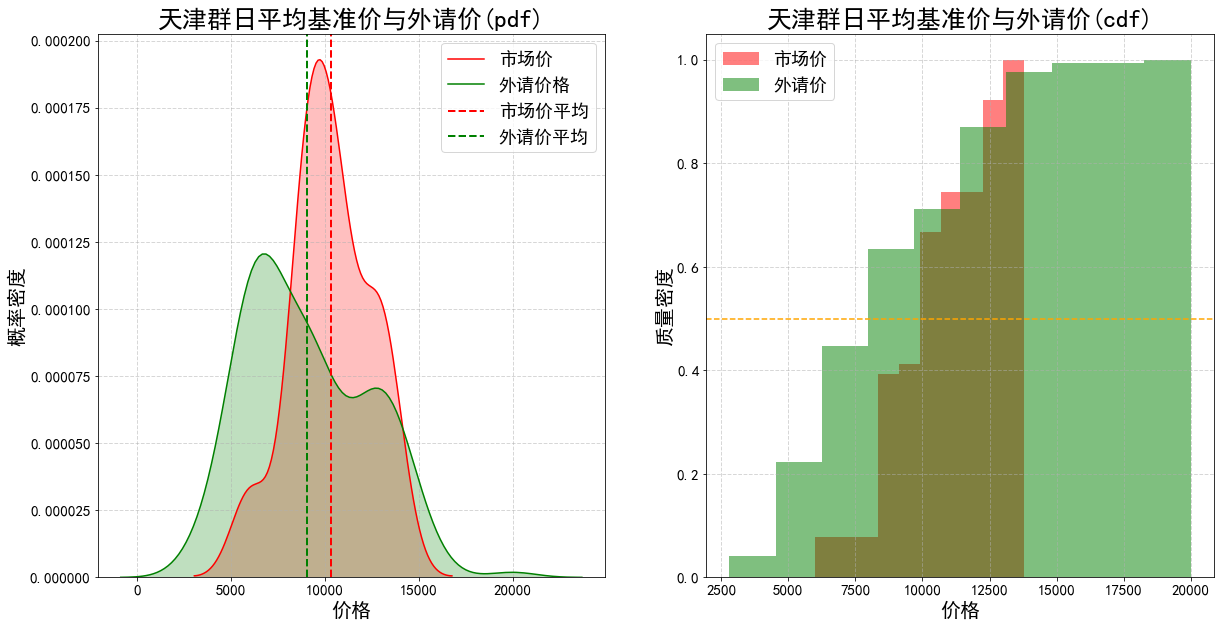

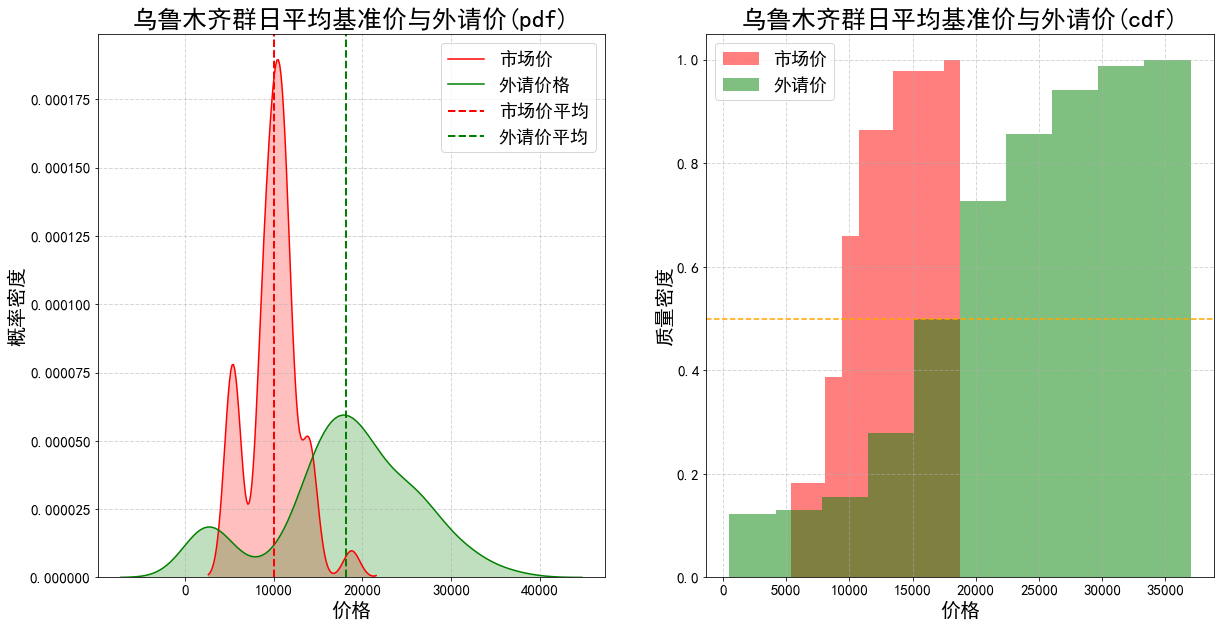

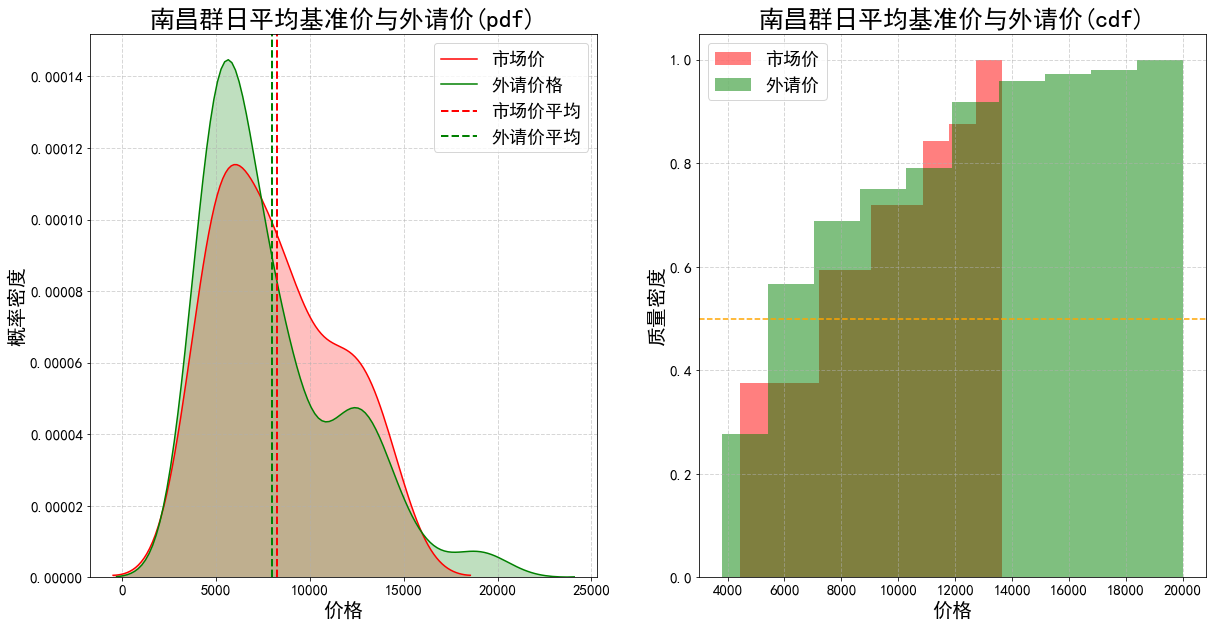

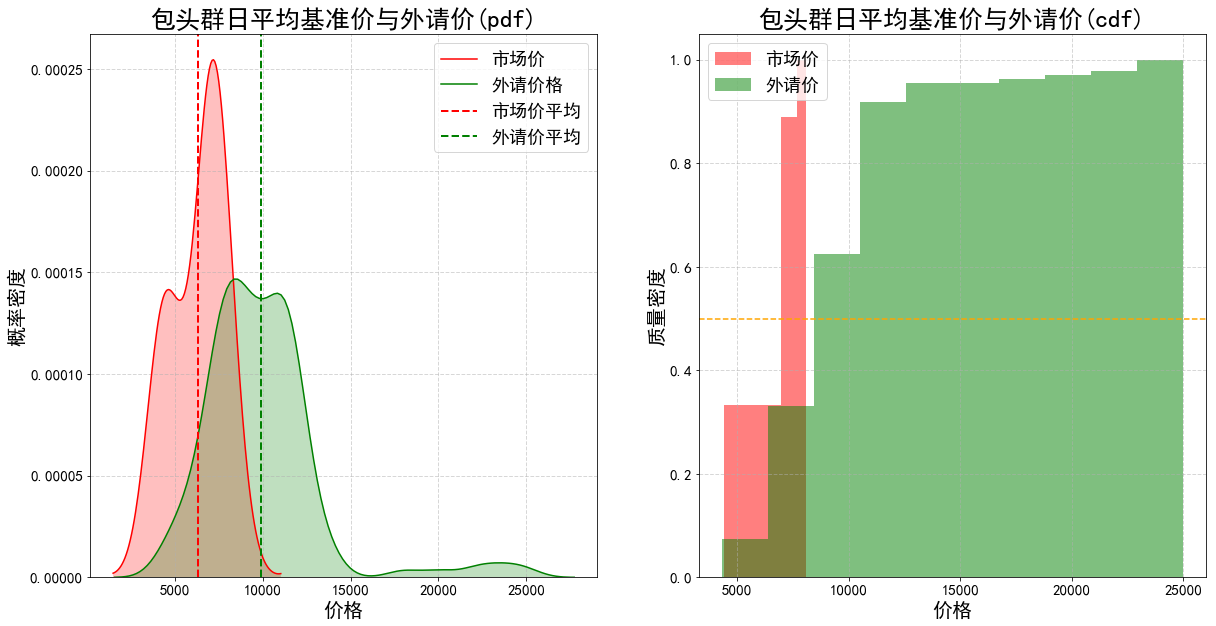

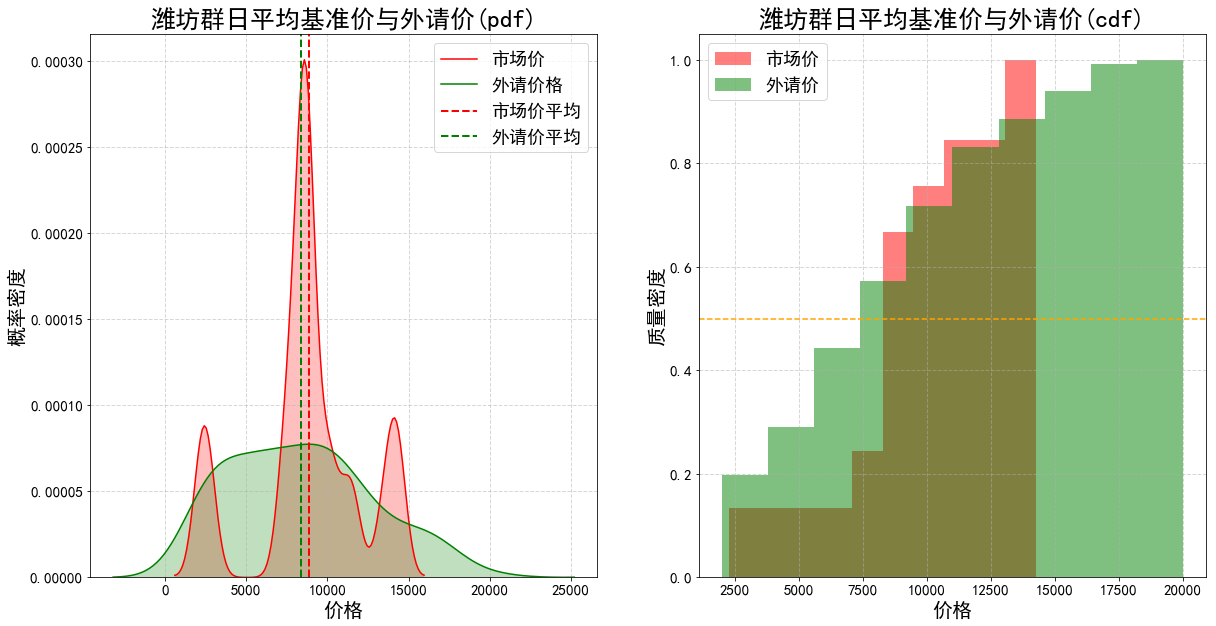

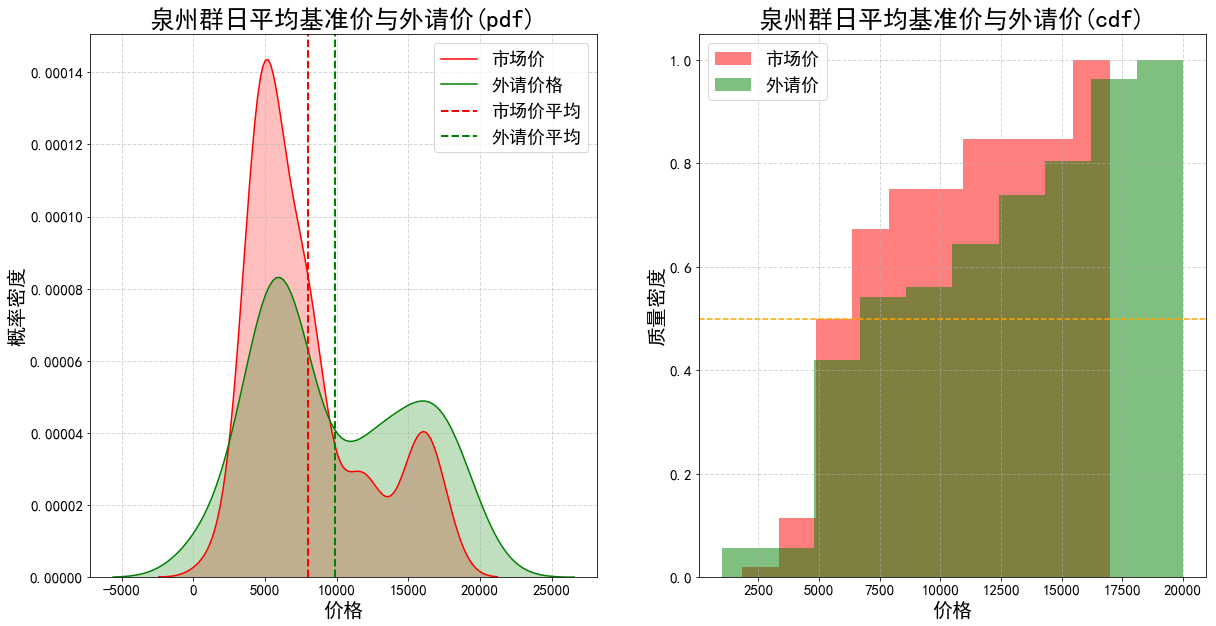

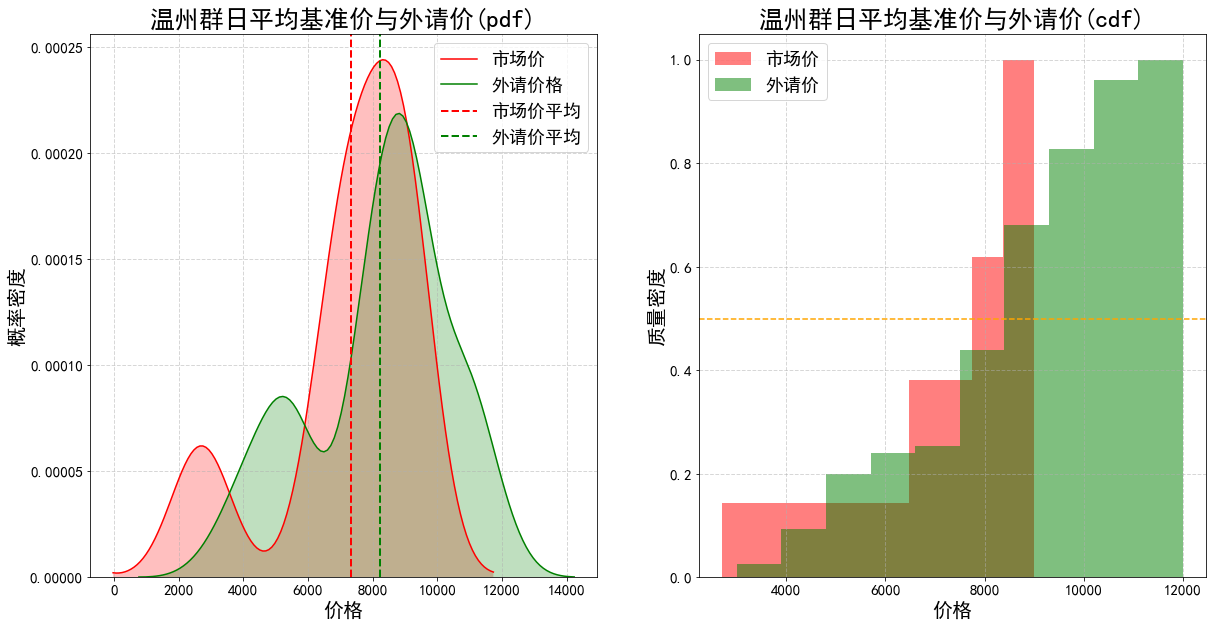

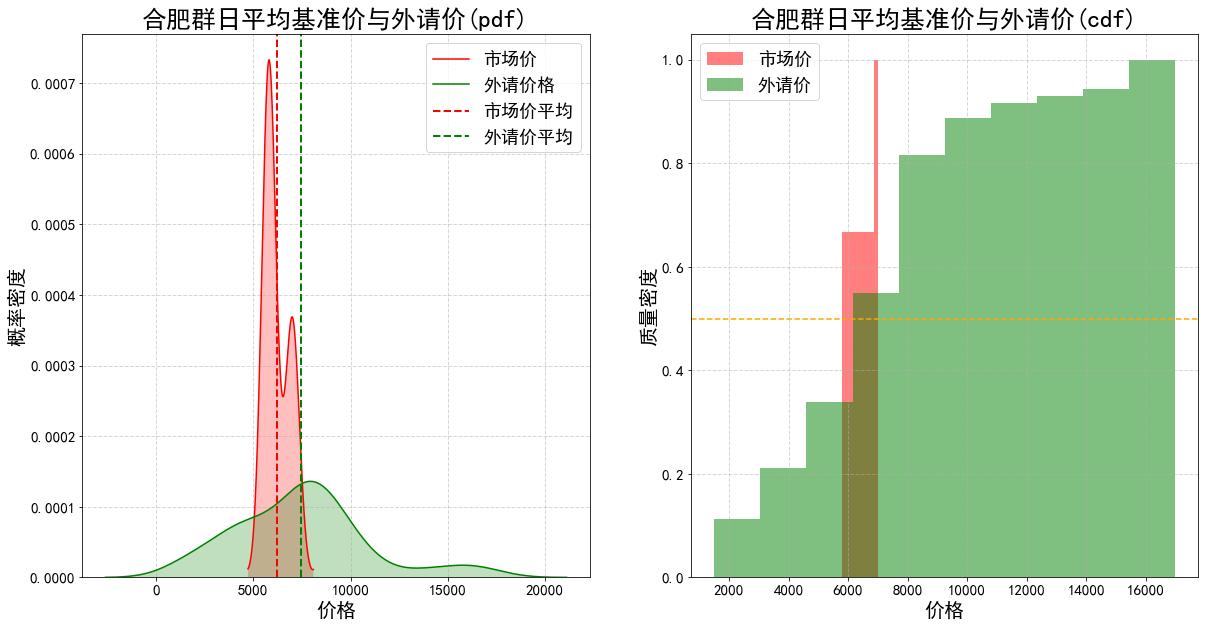

In [309]:
m = len(dfnew['from_city_cluster'].value_counts())
for i in range(0,20):
    distplot2(dfnew,i)

#### 潍坊、南昌、天津、临沂的外请价格 小于 或者等于 市场价格